# Regresja liniowa i logistyczna

## Wstęp

Celem tego laboratorium będzie stworzenie modelu uczenia maszynowego do estymacji cen nieruchomości na podstawie danych o jej położeniu, ilości sypialń, roku budowy, typie budynku oraz wielu innych parametrów.

![house-price-gif](house-price.gif)

W trakcie realizacji tego labratorium zapoznamy się z następującymi zagadnieniami:

* przygotowaniem danych:
    * ładowaniem danych,
    * typami danych,
    * czyszczeniem danych,
    * rozkładami danych,
    * obsługą wartości brakujących,
    * zmiennymi kategorycznymi uporządkowanymi i nieuporządkowanymi,
    * skalowaniem wartości,
    * API biblioteki Scikit-Learn dla transformacji danych;
* regresją liniową, w szczególności z:
    * podziałem zbioru na część treningową i testową,
    * oceną jakości modelu,
    * walidacją skrośną,
    * wyszukiwaniem hiperparametrów,
    * problemem przeuczenia, niedouczenia,
    * regularyzacją L1 i L2,
    * regresją wielomianową;
* regresją logistyczną, w szczególności z:
    * różnymi rodzajami błędów klasyfikacji,
    * metrykami oceniającymi jakość klasyfikatorów.

Na pierwszych zajęciach możesz korzystać ze środowiska Google Colab i zdalnego środowiska obliczeniowego. Jeżeli interesuje Cię skonfigurowanie Pythona  na własnym komputerze, to niezbędne informacje są podane w sekcji "Konfiguracja własnego komputera".

**Uwaga:** niektóre zadania zamiast kodu wymagają podania pisemnej odpowiedzi w miejscu oznaczonym `// skomentuj tutaj`.

## Wykorzystywane biblioteki

Na zajęciach korzystać będziesz z kilku popularnych bibliotek Pythona, które umożliwiają klasyfikację danych, ich wizualizację czy preprocessing. Są to:

* [numpy](https://numpy.org/) - bibliotek do wykonywania obliczeń macierzowych. Pozwala na efektywne przeprowadzanie obliczeń naukowych. Dobrze współgra z biblioteką pandas.
* [pandas](https://pandas.pydata.org/) - narzędzie do analizy danych tabelarycznych, ich strukturyzowania oraz manipulacji na nich.
* [sklearn](https://scikit-learn.org/stable/) - narzędzie do tworzenia modeli klasyfikacji, regresji, clusteringu itp. Biblioteka ta jest dość rozbudowana i pozwala także na mapowanie danych czy redukcję wymiarów. Więcej informacji znajdziesz w podanym linku.
* [missingno](https://pypi.org/project/missingno/) - narzędzie do wizualizacji kompletności danych (brakujących wartości).
* [seaborn](https://seaborn.pydata.org/) - kompleksowe narzędzie do wizualizacji danych jako takich. Pozwala na stworzenie bardzo szerokiej gamy wykresów w zależności od potrzeb.

Zostały tutaj pominięte pewne standardowe biblioteki jak np. `os` czy `matplotlib`.

## Wykorzystanie Google Colab

Korzystanie Google Colab nie jest wymagane. W niektórych laboratorich może być jednak przydatny dostęp do środowiska wyposażonego w kartę GPU.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/apohllo/sztuczna-inteligencja/blob/master/lab1/lab_1.ipynb)

Jeżeli pracujesz na Google Colab, zacznij od przeniesienia dwóch plików CSV, które zostały dołączone do laboratorium ([ames_data.csv](ames_data.csv) oraz [bank_marketing_data.csv](bank_marketing_data.csv)), do folderu `/content`. Nie musisz ich umieszczać w `/content/sample_data` - ważne, aby znalazły się w `/content`. Jeżeli pracujesz lokalnie, to wystarczy, że pliki te będą obok tego notebooka.


## Konfiguracja własnego komputera

Jeżeli korzystasz z własnego komputera, to musisz zainstalować trochę więcej bibliotek (Google Colab ma je już zainstalowane). Najlepiej używać Pythona 3.9 lub nowszej wersji. Laboratorium było testowane z wersją 3.9.

### Anaconda

Jeżeli korzystasz z Anacondy (możesz uruchomić w terminalu):

In [138]:
# !conda install -c conda-forge --yes numpy pandas scikit-learn matplotlib missingno

### venv

Jeżeli używasz zwykłego venv'a (**zdecydowanie niezalecane, szczególnie na Windowsie**):

In [139]:
# !pip install --yes numpy pandas scikit-learn matplotlib missingno

W przypadku własnego komputera, jeżeli instalowałeś z terminala, pamiętaj, aby zarejestrować aktualne środowisko wirtualne jako kernel (środowisko uruchomieniowe) dla Jupyter Notebooka. Wybierz go jako używany kernel w menu na górze notebooka (nazwa jak w komendzie poniżej).

In [140]:
# !ipython kernel install --user --name "PSI"

## Zbiór danych do regresji

Wykorzystamy zbiór danych [Ames housing](https://www.openintro.org/book/statdata/?data=ames), w którym zadaniem jest przewidywanie wartości domu na podstawie cech budynku, działki, lokalizacji itp. Jest to więc przewidywanie wartości ciągłej, czyli regresja. Zbiór ten zawiera zmienne numeryczne (floaty i inty), kategoryczne nieuporządkowane (*categorical nominal*) oraz kategoryczne uporządkowane (*categorical ordinal*), więc będzie wymagał wstępnego przetworzenia tak jak większość prawdziwych danych w uczeniu maszynowym.

Inne znane, ale gorsze jakościowo zbiory tego typu, to na przykład:
- Boston housing - rasistowski, z tego powodu usunięty np. ze Scikit-learn ([wyjaśnienie](https://fairlearn.org/main/user_guide/datasets/boston_housing_data.html), [dyskusja](https://github.com/quantumblacklabs/causalnex/issues/92), [badanie](https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8))
- California housing - zbyt prosty (tylko kilka zmiennych numerycznych), użyty np. w książce "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" A. Geron ([opis](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html))

Autor zbioru to Dean De Cock, a zbiór został opisany oryginalnie w [tym artykule](https://jse.amstat.org/v19n3/decock.pdf). 

In [141]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Ładowanie danych tabelarycznych


Pliki [ames_data.csv](ames_data.csv) oraz [bank_marketing_data.csv](bank_marketing_data.csv) to dwa zbiory danych, niezależne od siebie. Pierwszy jest wykorzystywany w pierwszej części laboratorium (regresji liniowej), natomiast drugi przyda się przy regresji logistycznej (klasyfikacji). Jego celem jest przewidywanie wartości domu.

Wczytajmy dane `ames_data.csv` do zmiennej `df` (takiej nazwy często się używa, żeby oznaczyć obiekt `DataFrame` - zaawansowanej tablicy, dostarczonej nam przez bibliotekę `pandas`).

In [142]:
df = pd.read_csv("ames_data.csv")

# remove dots from names to match data_description.txt
df.columns = [col.replace(".", "") for col in df.columns]

Zobaczmy jakie dane znajdują się w naszej tabeli. Wykorzystajmy do tego metodę `info()`.

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order          2930 non-null   int64  
 1   PID            2930 non-null   int64  
 2   MSSubClass     2930 non-null   int64  
 3   MSZoning       2930 non-null   object 
 4   LotFrontage    2440 non-null   float64
 5   LotArea        2930 non-null   int64  
 6   Street         2930 non-null   object 
 7   Alley          198 non-null    object 
 8   LotShape       2930 non-null   object 
 9   LandContour    2930 non-null   object 
 10  Utilities      2930 non-null   object 
 11  LotConfig      2930 non-null   object 
 12  LandSlope      2930 non-null   object 
 13  Neighborhood   2930 non-null   object 
 14  Condition1     2930 non-null   object 
 15  Condition2     2930 non-null   object 
 16  BldgType       2930 non-null   object 
 17  HouseStyle     2930 non-null   object 
 18  OverallQ

Mamy naprawdę dużo cech! Ich szczegółowy opis znajdziesz w dołączonym do laboratorium pliku [ames_description.txt](ames_description.txt).

### Wstępna analiza danych

Zawsze, zanim zaczniesz robić jakąkolwiek predykcję czy analizę danych, dobrze jest zapoznać się z nimi, z ich kodowaniem i znaczeniem. Kolejnym istotnym aspektem jest typ danych. Nie każdy klasyfikator nadaje się do każdego typu.

Wyświetlmy teraz kilka przykładowych rekordów z początku pliku, korzystając z metody `head()`.

In [144]:
df.head()

,Order,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


Jeżeli potrzebujesz szybko stwierdzić, ile dane zawierają rekordów i kolumn, pomocna jest opcja `shape`:

In [145]:
df.shape

(2930, 82)

## Eksploracja danych, czyszczenie danych i inżynieria cech

### Usunięcie niepotrzebnych kolumn

Niektóre kolumny są **nieinformatywne (uninformative)**, czyli nie niosą żadnej informacji dla zadania, czyli przewidywania wartości domu. Są pewnym rodzajem metadanych. Przykładowo mamy tutaj kolumny **Order** oraz **PID**.

**Order** jest po prostu numerem rekordu w zbiorze danych, moglibyśmy przetasować cały zbiór i to nie powinno w żaden sposób wpłynąć na cokolwiek, a więc możemy spokojnie tę kolumnę usunąć.

Formalnie czynimy założenie, że rekordy w naszych danych (próbki / wiersze, poszczególne domy w przypadku tego zbioru) są **niezależne i równomiernie rozłożone** (ang. **independent and identically distributed - i.i.d.**). Innymi słowy, kolejność w danych nie ma znaczenia, bo zbieraliśmy dane taką samą metodą i w identycznych warunkach. Jest to bardzo typowe w ML.

**PID** jest po prostu numerem identyfikacyjnym danej nieruchomości w systemie informatycznym, a więc też możemy to usunąć.

In [146]:
df = df.drop(["Order", "PID"], axis="columns")

### Usunięcie słabo reprezentowanych dzielnic

Dzielnice *GrnHill* oraz *Landmrk* obejmują w sumie zaledwie 3 domy.

In [147]:
df = df.loc[~df["Neighborhood"].isin(["GrnHill", "Landmrk"]), :]

### Usunięcie obserwacji odstających (outliers)

Usuniemy budynki, które mają powyżej 4000 stóp kwadratowych (ok. 370 metrów kwadratowych) powierzchni. Możemy zobaczyć je na wykresie poniżej. 

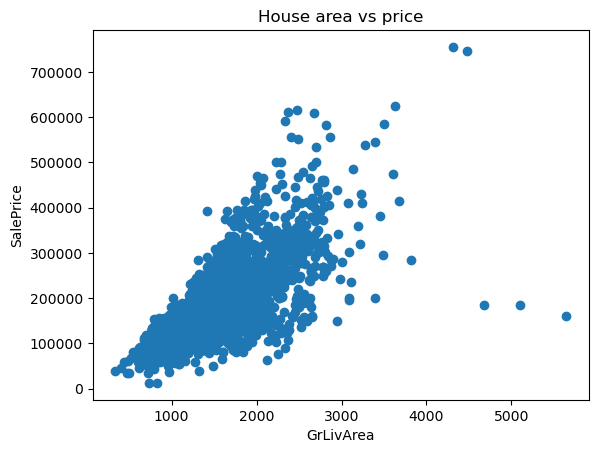

In [148]:
plt.scatter(df["GrLivArea"], df["SalePrice"])
plt.title("House area vs price")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

Jak widać na wykresie, jest dosłownie kilka domów o tej powierzhcni. Takie skrajne przypadki raczej nas nie interesują - a na pewno stanowią problem dla tak prostego modelu jak regresja logistyczna. Nie chcemy też, żeby nasz model uczył się takich anomalii, więc lepiej je usunąć.

Tutaj robimy to ręcznie, ale istnieją też algorytmy do detekcji i usuwania obserwacji odstających.

**Zadanie 1 (0.25 punktu)**

Usuń rekordy nieruchomości o powierzchni (**GrLivArea**) ponad (ostra nierówność) 4 tys. stóp kwadratowych.

Podpowiedź: w Pandas korzysta się z `.loc[]` do filtrowania wierszy i kolumn. Pierwszy indeks oznacza, które wiersze zostawić, a drugi indeks, które kolumny wybrać. Jeżeli chcemy zostawić wszystko (np. nie usuwać żadnych kolumn), to zadziała standardowy Pythonowy `:`, jak przy indeksowaniu list.

In [149]:
# remove outliers
df = df.loc[df['GrLivArea'] <= 4000, :]

Zobaczmy jak teraz wygląda ten sam wykres.

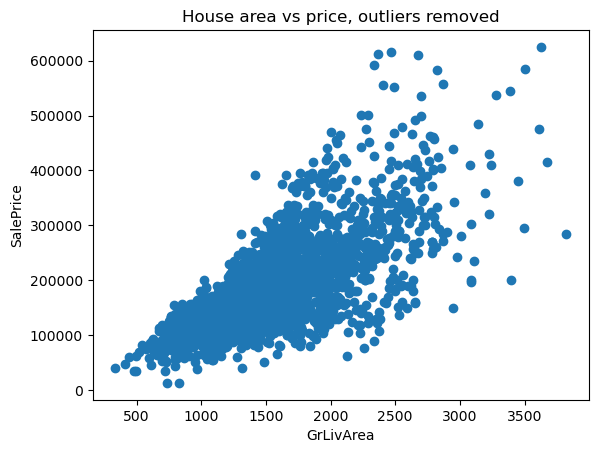

In [150]:
plt.scatter(df["GrLivArea"], df["SalePrice"])
plt.title("House area vs price, outliers removed")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

### Transformacja logarytmiczna zmiennej zależnej

Zawsze warto też przyjrzeć się rozkładowi zmiennej docelowej, żeby poznać jej typ i skalę. Jak widać poniżej, rozkład jest dość skośny, co ma sens - mało jest bardzo drogich domów.

In [151]:
df["SalePrice"].describe()

count      2922.000000
mean     180358.266940
std       78536.952287
min       12789.000000
25%      129425.000000
50%      160000.000000
75%      213430.000000
max      625000.000000
Name: SalePrice, dtype: float64

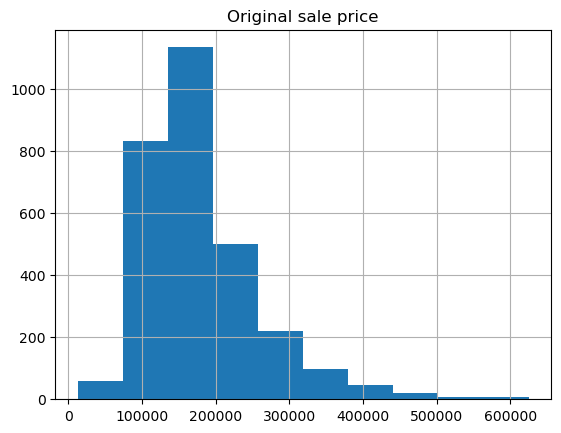

In [152]:
df["SalePrice"].hist()
plt.title("Original sale price")
plt.show()

Rozkład normalny jest zwykle korzystniejszy dla tworzenia modeli, bo daje sensowną "wartość środkową" do przewidywania, a także penalizuje tak samo błędy niezależnie od ich znaku (zaniżona i zawyżona predykcja). Dokonamy dlatego **transformacji logarytmicznej (log transform)**, czyli zlogarytmujemy zmienną docelową (zależną). Dla stabilności numerycznej używa się zwykle `np.log1p`, a nie `np.log` (tutaj [wyjaśnienie](https://stackoverflow.com/questions/49538185/purpose-of-numpy-log1p)).

Dodatkowa korzyść z takiej transformacji jest taka, że regresja liniowa przewiduje dowolne wartości rzeczywiste. Po przekształceniu logarytmicznym jest to całkowicie ok, natomiast w oryginalnej przestrzeni trzeba by wymusić przewidywanie tylko wartości pozytywnych (negatywne ceny są bez sensu). Da się to zrobić, ale zwiększa to koszt obliczeniowy. Operowanie na tzw. log-price jest bardzo częste w finansach.

**Zadanie 2 (0.25 punktu)**

Przekształć zmienną **SalePrice** za pomocą funkcji logarytmicznej `np.log1p`.

In [153]:
# apply log transform
df['SalePrice'] = np.log1p(df['SalePrice'])

Sprawdźmy teraz jak rozkład **SalePrice** wygląda po transformacji:

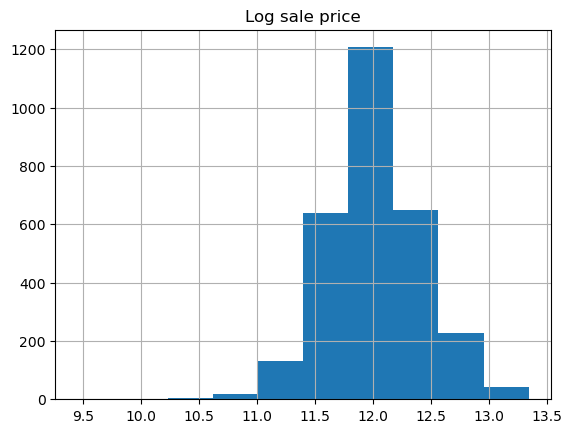

In [154]:
pd.Series(df["SalePrice"]).hist()
plt.title("Log sale price")
plt.show()

### Uzupełnianie wartości brakujących

Sprawdźmy też wartości brakujące. Są zmienne, które mają poniżej 10% wartości - takie zmienne dla modeli regresji liniowej są po prostu bezużyteczne, ponieważ brakujących wartości nie można wprost zamodelować. Znacząca liczba cech ma jednak co najmniej 10% braków. Z nich będziemy jednak starali się zrobić użytek.

In [155]:
import missingno as msno

# msno.bar(df)

W ramach dalszego czyszczenia danych automatycznie uzupełnimy wartości brakujące. Trzeba tu jednak wziąć pod uwagę:
- zmienne kategoryczne - nie można w nich dokonać zastąpienia wartości brakującej średnią, medianą itp.
- wiele brakujących wartości - estymacja modą czy medianą byłaby niedokładna,
- możliwość wykorzystania wiedzy o innych zmiennych na podstawie opisu cech.

Można więc zastosować odpowiednią wiedzę i przyjąć wartości domyślne. Przykładowo, brak informacji o powierzchni piwnicy możemy uznać po prostu za brak piwnicy i wpisać tam odpowiednią wartość. W przypadku niektórych zmiennych może doprowadzić to do stworzenia nowej wartości, która implicite będzie reprezentować wartość brakującą.

Znaczna część poniższej analizy została zainspirowana [tym notebookiem na Kaggle](https://www.kaggle.com/code/juliencs/a-study-on-regression-applied-to-the-ames-dataset).

In [156]:
def replace_na(df: pd.DataFrame, col: str, value) -> None:
    df.loc[:, col] = df.loc[:, col].fillna(value)

In [157]:
# Alley : data description says NA means "no alley access"
replace_na(df, "Alley", value="None")

# BedroomAbvGr : NA most likely means 0
replace_na(df, "BedroomAbvGr", value=0)

# BsmtQual etc : data description says NA for basement features is "no basement"
replace_na(df, "BsmtQual", value="No")
replace_na(df, "BsmtCond", value="No")
replace_na(df, "BsmtExposure", value="No")
replace_na(df, "BsmtFinType1", value="No")
replace_na(df, "BsmtFinType2", value="No")
replace_na(df, "BsmtFullBath", value=0)
replace_na(df, "BsmtHalfBath", value=0)
replace_na(df, "BsmtUnfSF", value=0)

# Condition : NA most likely means Normal
replace_na(df, "Condition1", value="Norm")
replace_na(df, "Condition2", value="Norm")

# External stuff : NA most likely means average
replace_na(df, "ExterCond", value="TA")
replace_na(df, "ExterQual", value="TA")

# Fence : data description says NA means "no fence"
replace_na(df, "Fence", value="No")

# Functional : data description says NA means typical
replace_na(df, "Functional", value="Typ")

# GarageType etc : data description says NA for garage features is "no garage"
replace_na(df, "GarageType", value="No")
replace_na(df, "GarageFinish", value="No")
replace_na(df, "GarageQual", value="No")
replace_na(df, "GarageCond", value="No")
replace_na(df, "GarageArea", value=0)
replace_na(df, "GarageCars", value=0)

# HalfBath : NA most likely means no half baths above grade
replace_na(df, "HalfBath", value=0)

# HeatingQC : NA most likely means typical
replace_na(df, "HeatingQC", value="Ta")

# KitchenAbvGr : NA most likely means 0
replace_na(df, "KitchenAbvGr", value=0)

# KitchenQual : NA most likely means typical
replace_na(df, "KitchenQual", value="TA")

# LotFrontage : NA most likely means no lot frontage
replace_na(df, "LotFrontage", value=0)

# LotShape : NA most likely means regular
replace_na(df, "LotShape", value="Reg")

# MasVnrType : NA most likely means no veneer
replace_na(df, "MasVnrType", value="None")
replace_na(df, "MasVnrArea", value=0)

# MiscFeature : data description says NA means "no misc feature"
replace_na(df, "MiscFeature", value="No")
replace_na(df, "MiscVal", value=0)

# OpenPorchSF : NA most likely means no open porch
replace_na(df, "OpenPorchSF", value=0)

# PavedDrive : NA most likely means not paved
replace_na(df, "PavedDrive", value="N")

# PoolQC : data description says NA means "no pool"
replace_na(df, "PoolQC", value="No")
replace_na(df, "PoolArea", value=0)

# SaleCondition : NA most likely means normal sale
replace_na(df, "SaleCondition", value="Normal")

# ScreenPorch : NA most likely means no screen porch
replace_na(df, "ScreenPorch", value=0)

# TotRmsAbvGrd : NA most likely means 0
replace_na(df, "TotRmsAbvGrd", value=0)

# Utilities : NA most likely means all public utilities
replace_na(df, "Utilities", value="AllPub")

# WoodDeckSF : NA most likely means no wood deck
replace_na(df, "WoodDeckSF", value=0)

W przypadku wykonywania tego typu zmian - o ile istnieje taka możliwość - warto rozważyć różne interpretacje brakujących wartości. Może okazać się, że przyjęte przez nas założenia są błędne i prowadzą do pogorszenia działania modelu. Dlatego warto porównać jakoś predykcji z danymi uzupełnionymi oraz z danymi, w których kolumna z brakującymi wartościami jest po prostu usuwana.

**Zadanie 3 (0.5 punktu)**

Z pomocą dokumentacji zmiennych w pliku [ames_description.txt](ames_description.txt) zdecyduj, jakie wartości domyślne przypisać zmiennym:
- `CentralAir`
- `EnclosedPorch`
- `FireplaceQu` oraz `Fireplaces`
- `SaleCondition`

W praktyce niestety zwykle nie jest tak łatwo, że mamy dokumentację i ten krok zajmuje kilka godzin (lub dni) konsultacji z różnymi osobami w firmie :) 
Czasami w ogóle nie da się ustalić jaka wartość byłaby sensowna, ponieważ nie mamy żadnego dostępu do osób odpowiedzialnych za przygotowanie wykorzystywanego zbioru danych.

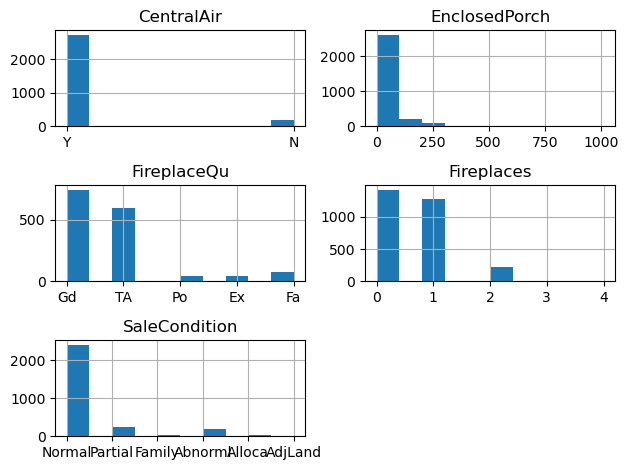

In [158]:
plt.subplot(3,2,1)
df['CentralAir'].hist()
plt.title('CentralAir')

plt.subplot(3,2,2)
df['EnclosedPorch'].hist()
plt.title('EnclosedPorch')

plt.subplot(3,2,3)
df['FireplaceQu'].hist()
plt.title('FireplaceQu')

plt.subplot(3,2,4)
df['Fireplaces'].hist()
plt.title('Fireplaces')

plt.subplot(3,2,5)
df['SaleCondition'].hist()
plt.title('SaleCondition')

plt.tight_layout()
plt.show()



In [159]:
# your_code
# CentralAir : Most homes CentralAir so Y
replace_na(df, "CentralAir", value="Y")

# EnclosedPorch : NA most likely means no enclosed porch
replace_na(df, "EnclosedPorch", value=0)

# Fireplaces : NA most likely means no fireplaces
replace_na(df, "Fireplaces", value=0)

# FireplaceQu : NA most likely means no fireplaces, and no quality 
replace_na(df, "FireplaceQu", value="No")

# SaleCondition : NA most likely means normal
replace_na(df, "SaleCondition", value="Normal")


### Dane kategoryczne

Jak już zdążyliśmy zauważyć, istnieją dwa główne rodzaje danych: numeryczne (*numerical data*) oraz kategoryczne (*categorical data*). Ten podział jest bardzo istotny. Dane numeryczne to żadna niespodzianka, po prostu mają swoją wartość, jak np. **GrLivArea**, czyli powierzchnia budynku/apartamentów. Dane kategoryczne to takie, którym w większości przypadków nie można przyporządkować wartości liczbowej (wyjątkiem są dane kategoryczne uporządkowane - *categorical ordinal*).

Wyobraź sobie zmienną reprezentującą kolory o wartościach "red", "green" i "blue. Jeżeli zakodowałbyś je np. jako $red = 0$, $green = 1$, $blue = 2$, to stwierdzasz tym samym, że w pewnym sensie $red < green < blue$. Raczej nie ma powodu, żeby tak sądzić. Jest to zmienna, która ma skończoną liczbę wartości, ale są one nieuporządkowane. Taki typ to zmienne *categorical nominal*.

Szczególnym przypadkiem są zmienne binarne (*boolean*). Jest to u nas kolumna **CentralAir** (Central Air Conditioning). Z opisu w pliku [ames_description.txt](ames_description.txt) wiemy, że przyjmuje ona dokładnie dwie wartości kategoryczne: *No* oraz *Yes*. W takiej sytuacji wolno zakodować te wartości numerycznie jako 0 i 1. Stwierdzasz tym samym, że klimatyzacja albo jest, albo jej nie ma.

Sytuacją podobną, chociaż mniej oczywistą, może być zmienna **Street**, opisująca typ drogi wiodącej do nieruchomości. Jeśli znowu spojrzymy do opisu danych, to można zauważyć, że ta zmienna może przyjmować tylko dwie różne wartości - *Grvl* i *Pave*. I tu też możemy sobie pozwolić na zakodowanie tych wartości jako 0 i 1. Stwierdzamy wtedy, że droga jest *utwardzona* (Pave) dla wartości 1. Oczywiście równie dobrze można by zakodować to odwrotnie i stwierdzić, że droga jest *nieutwardzona* (Grvl) gdy wartość wynosi 1.

W Pandas typy numeryczne są oparte o NumPy (np. `np.int64`), a zmienne kategoryczne, napisy itp. są typu `object` (typ `Categorical` istnieje od pewnego czasu, ale nie jest jeszcze zbyt dobrze wspierany).

Zmienne **MSSubClass** oraz **MoSold** są kategoryczne (tak wynika z informacji zawartej w pliku [ames_description.txt](ames_description.txt)), a są w naszych danych wprost liczbami. Przekształćmy je zatem do poprawnego typu.

In [160]:
df = df.replace(
    {
        "MSSubClass": {
            20: "SC20",
            30: "SC30",
            40: "SC40",
            45: "SC45",
            50: "SC50",
            60: "SC60",
            70: "SC70",
            75: "SC75",
            80: "SC80",
            85: "SC85",
            90: "SC90",
            120: "SC120",
            150: "SC150",
            160: "SC160",
            180: "SC180",
            190: "SC190",
        },
        "MoSold": {
            1: "Jan",
            2: "Feb",
            3: "Mar",
            4: "Apr",
            5: "May",
            6: "Jun",
            7: "Jul",
            8: "Aug",
            9: "Sep",
            10: "Oct",
            11: "Nov",
            12: "Dec",
        },
    }
)

Oprócz tego zakodujemy zmienne kategoryczne uporządkowane (*categorical ordinal*) z tekstowych na kolejne liczby całkowite.

Przykładowo zmienna **BsmtCond**, oceniająca stan piwnicy, ma następujące możliwe wartości:
* *NA* (No) Basement
* *Po* (Poor) - Severe cracking, settling, or wetness
* *Fa* (Fair) - dampness or some cracking or settling
* *TA* (Typical) - slight dampness allowed
* *Gd* (Good)
* *Ex* (Excellent)

Do następujących wartości możemy dopasować pewną skalę punktową, bo są one naturalnie uporządkowane.

In [161]:
df = df.replace(
    {
        "Alley": {"None": 0, "Grvl": 1, "Pave": 2},
        "BsmtCond": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "BsmtExposure": {"No": 0, "Mn": 1, "Av": 2, "Gd": 3},
        "BsmtFinType1": {
            "No": 0,
            "Unf": 1,
            "LwQ": 2,
            "Rec": 3,
            "BLQ": 4,
            "ALQ": 5,
            "GLQ": 6,
        },
        "BsmtFinType2": {
            "No": 0,
            "Unf": 1,
            "LwQ": 2,
            "Rec": 3,
            "BLQ": 4,
            "ALQ": 5,
            "GLQ": 6,
        },
        "BsmtQual": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "ExterCond": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "ExterQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "FireplaceQu": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "Functional": {
            "Sal": 1,
            "Sev": 2,
            "Maj2": 3,
            "Maj1": 4,
            "Mod": 5,
            "Min2": 6,
            "Min1": 7,
            "Typ": 8,
        },
        "GarageCond": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "GarageQual": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "HeatingQC": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "KitchenQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "LandSlope": {"Sev": 1, "Mod": 2, "Gtl": 3},
        "LotShape": {"IR3": 1, "IR2": 2, "IR1": 3, "Reg": 4},
        "PavedDrive": {"N": 0, "P": 1, "Y": 2},
        "PoolQC": {"No": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
        "Street": {"Grvl": 0, "Pave": 1},
        "Utilities": {"ELO": 1, "NoSeWa": 2, "NoSewr": 3, "AllPub": 4},
    }
)

## Przygotowanie danych do uczenia


Nasz zbiór podzielimy na dwa podzbiory: treningowy (70%) i testowy (30%). Zbiór treningowy pozwoli nam utworzyć model regresji liniowej, natomiast testowy - oszacować jego jakość.

Pamiętaj, że wyniki uzyskiwane przez model na danych treningowych nie odzwierciedlają tego, jak będzie on sobie radził na danych, których nie ma w zbiorze uczącym. Aby uzyskać taką informację, konieczne jest sprawdzenie, jak model radzi sobie na danych testowych. Daje nam to oszacowanie, jak dobrze model **generalizuje się** dla nowych danych.

Wydzielimy sobie równeż zbiory kolumn z danymi numerycznymi i kategorycznymi, co później ułatwi nam odwoływanie się do nich.

Funkcja `train_test_split` z biblioteki Scikit-Learn przyjmuje osobno macierze dla cech (*features*) i etykiet (*labels*), dlatego wyodrębniamy sobie z naszej tablicy kolumnę **SalePrice**, która zawiera ceny nieruchomości.

---
#### *Ciekawostka*

Można zauważyć, że zmienna `y` jest małą literą, natomiast `X_train` czy `X_test` są z dużej. Są to konwencje pochodzące z matematyki:

* wektor w matematyce często oznaczamy małą pogrubioną literą ($\textbf{y}$) - w programowaniu natomiast oznaczamy po prostu małą literą - `y`
* macierz w matematyce oznaczamy dużą pogrubioną literą ($\textbf{X}$) - w programowaniu po prostu dużą literą - `X`

Zbiór etykiet to w naszym przypadku wektor cen, więc zapisujemy `y` małą literą. Z drugiej strony `X` zawiera kolumny z cechami opisującymi poszczególne rekordy, a więc jest to macierz.

---

**Uwaga**: w eksperymentach ustalamy na sztywno wartość parametru `random_state`. [Doczytaj](https://scikit-learn.org/stable/glossary.html#term-random_state), dlaczego wykorzystywany jest ten parametr i co się dzieje, gdy jest on równy stałej wartości jak zero.

In [162]:
from sklearn.model_selection import train_test_split

y = df.pop("SalePrice")

categorical_features = df.select_dtypes(include="object").columns
numerical_features = df.select_dtypes(exclude="object").columns

X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.3, random_state=0
)

Teraz trzeba dokonać transformacji naszych danych:
- zmienne kategoryczne nieuporządkowane trzeba przetworzyć tak, aby nasz algorym był w stanie je obsłużyć, czyli je zakodować za pomocą **one-hot encoding**,
- zmienne numeryczne dalej mogą mieć wartości brakujące, więc trzeba je uzupełnić, inaczej **imputować (impute)**,
- zmienne numeryczne trzeba przeskalować do zakresu wartości $[0, 1]$ czyli je **znormalizować (normalization)** przez zastosowanie **min-max scaling**.



### Kodowanie one-hot encoding

Powyżej omawialiśmy zmienne kategoryczne. Typ *categorical ordinal* można zakodować kolejnymi liczbami całkowitymi, co jest oczywiście proste. Co jednak ze zmiennymi bez kolejności, typu *categorical nominal*? Trzeba je dalej przekształcić na liczby (żeby model był w stanie je przetworzyć), ale tak, aby nie nadać im implicite kolejności.

Spójrzmy na kolumnę **Neighborhood**, oznaczającą poszczególne dzielnice. Dom znajduje się tylko w jednej dzielnicy, a w pozostałych go nie ma. Idea kodowania **one-hot encoding** polega na stworzeniu tylu zmiennych, ile jest możliwych wartości, a następnie w każdym wierszu przypisanie wartości 1 w tej kolumnie, z której była oryginalnie zmienna.

Przykładowo, jeżeli mielibyśmy 3 wartości `["A", "B", "C"]`, to powstają z nich 3 cechy (kolumny macierzy `X`) `[col_A, col_B, col_C]`. Wiersz z pierwotną wartością `"B"` będzie miał wartości tych cech `[0, 1, 0]`. W przypadku naszej zmiennej **Neighborhood** pojawią się osobne zmienne **Old Town**, **NoRidge**, **Gilbert** itd., a dla każdego wiersza dokładnie jedna z nich będzie miała wartość 1.

#### Dla zainteresowanych

Jeżeli mamy dużo możliwych wartości, czyli zmienną o dużej **kardynalności (cardinality)**, to kolumn powstanie bardzo dużo. Do tego są **rzadkie (sparse)**, więc tracimy dużo pamięci na przechowywanie zer. Istnieją inne kodowania, które zajmują mniej miejsca, a implementuje je biblioteka [Category Encoders](https://contrib.scikit-learn.org/category_encoders/).


### Imputacja brakujących wartości numerycznych

Wcześniej już napotkaliśmy wartości brakujące i postaraliśmy się uzupełnić je jak najlepiej potrafiliśmy, używając dokumentacji naszego zbioru. Nie gwarantuje to jednak usunięcia wszystkich braków. Nie zawsze w praktyce da się też tak łatwo znaleźć wartości do uzupełnienia. W przypadku zwykłych cech numerycznych możemy zastosować jedną z kilku bardzo popularnych strategii radzenia sobie z wartościami brakującymi:

1. Usunąć kolumnę, która zawiera brakujące wartości.
1. Usunąć wiersze, w których brakuje wartości.
1. Zastąpić brakujące wartości innymi, np. średnią z kolumny, medianą albo wartością stałą.
1. Przewidzieć brakujące wartości wykorzystując odpowiedni model uczenia maszynowego.

Podejście 4 jest często zbyt czasochłonne. Opcje 1 i 2 prowadzą do utraty danych. My wypróbujemy sposób nr 3.

Nie znaczy to jednak, że usunięcie wierszy czy kolumny jest zawsze złym podejściem. Usunięcie kolumny jest uzasadnione, jeśli ma ona naprawdę dużo wartości brakujących. W takich wypadkach ciężko z niej wyciągnąć jakąkolwiek sensowną informację. Usunięcie wierszy może być uzasadnione w przypadku, gdy mamy dużo rekordów i tylko niewielka część z nich posiada wartości brakujące (usunięcie kilku wierszy nie powinno powodować problemu).

#### Dla zainteresowanych

Popularne algorytmy imputacji danych często są oparte [o algorytm najbliższych sąsiadów, czyli najbardziej podobne punkty](https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation). Innym podejściem, iteracyjnie imputującym wartości, jest [algorytm MICE](https://www.numpyninja.com/post/mice-algorithm-to-impute-missing-values-in-a-dataset).


### Skalowanie

Jest to bardzo ważny krok dla wielu modeli sztucznej inteligencji. Często takie modele mają pewne założenia co do danych wejściowych, a szczególnie popularnym założeniem jest, że wszystkie cechy mają wartości o podobnej skali. W szczególności regresja liniowa i logistyczna też czynią to założenie. Dlatego trzeba przeskalować nasze dane, żeby spełnić to założenie. Najprostsza metoda to `MinMaxScaler`, który przekształca wszystkie wartości do przedziału $[0, 1]$.

Istnieją też inne metody, np. standaryzacja, którą możesz pamiętać ze statystyki (jej wynikiem jest Z-score). Polega na odjęciu średniej i podzieleniu przez odchylenie standardowe każdej cechy. Wynikiem przekształcenia są cechy o średniej 0 i odchyleniu standardowym 1.

Więcej informacji na temat tego, dlaczego skalowanie jest tak istotne, możesz znaleźć [tutaj](https://analyticsindiamag.com/why-data-scaling-is-important-in-machine-learning-how-to-effectively-do-it/).

#### Dla zainteresowanych

Porównanie różnych metod skalowania [możesz znaleźć tutaj](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html). Ciekawą metodą jest np. RobustScaler, który jest podobny do StandardScaler, ale używa mediany i kwartyli zamiast średniej i odchylenia standardowego. Są to tzw. robust statistics, czyli miary odporne na występowanie wartości odstających (outliers).

## Przetwarzanie danych z wykorzystaniem Scikit-Learn

Mamy zatem do wykonania:
- na zmiennych numerycznych 2 operacje do wykonania: imputacja i skalowanie,
- na zmiennych kategorycznych: zastosowanie kodowania one-hot encoding.

W Scikit-learn służą do tego następujące klasy:
- `OneHotEncoder`, `SimpleImputer`, `MinMaxScaler` - transformacje, implementują metody `.fit()` i `.transform()`,
- `Pipeline` - do układania transformacji sekwencyjnie,
- `ColumnTransformer` - do układania transformacji równolegle, dla różnych kolumn.

**Ważne:** jako, że zaraz skorzystamy z regresji liniowej, do klasy `OneHotEncoder` trzeba przekazać `drop="first"`. Stworzy to 1 zmienną mniej, niż typowy one-hot encoding, np. `pd.get_dummies()`, gwarantując brak **idealnie współliniowych zmiennych (perfectly collinear features)**, co byłby niestabilny numerycznie. Dodatkowo, jako że przekształcamy już po podziale na zbiór treningowy i testowy, to możemy spotkać na zbiorze testowym nieliczne przypadki kategorii, których nie ma w zbiorze treningowym - kodujemy je wtedy po prostu jako wektory zer za pomocą `handle_unknown="ignore"`.

Na przykładzie `StandardScaler` (standaryzacja) rozpatrzmy, jak działają poszczególne metody.


### Metoda `.fit()`

Do wykonania standaryzacji potrzebujemy dla każdej z cech określić 2 wartości - średnią oraz odchylenie standardowe. Formuła standaryzacji dla przypomnienia:

$$z = \frac{x - \mu}{\sigma}$$

Metodę `.fit()` wykonujemy tylko raz, dla **danych treningowych**. To powoduje, że obliczamy wartości $\mu$ oraz $\sigma$ dla każdej cechy, na podstawie wartości ze zbioru treningowego. Wyuczone wartości zostają zapisane w obiekcie `StandardScaler` i mogą być później używane do przeprowadzenia standaryzacji zarówno dla danych treningowych, jak i testowych.

**Co, gdyby dla danych testowych przeprowadzić osobną standaryzację?**

Będziemy, na przykład, standaryzować kolumnę **GrLivArea** - powierzchnię nieruchomości. Załóżmy, że z danych treningowych wyszłoby, że średnia jest równa $60m^2$, a odchylenie standardowe - $20m^2$. Wtedy wartości z przedziału $[40, 80]$ zostaną przekształcone do $[-1, 1]$. Nasz model wykorzysta to przekształcenie i będzie uważał, że wartości po transformacji w pobliżu $0$ oznaczają średniej wielkości apartamenty.

Określiliśmy parametry modelu i dostajemy kilkadziesiąt budynków z jakiejś zamożnej dzielnicy dla predykcji. Średnia powierzchnia dla tych budynków to około $160m^2$. Osobno przeprowadzając standaryzację dla takich danych testowych, zaburzylibyśmy rozkład tej cechy, gdyż tym razem wartości wokół $0$ oznaczałyby dość duże mieszkania. Modele są niezwykle czułe na podobne zaburzenia - musimy przetwarzać dane spójnie, żeby nie doszło do podobnych sytuacji. 

**Czemu nie wywołać `.fit()` na wszystkich danych, a nie tylko treningowych?**

Wydzieliliśmy dane testowe po to, żeby sprawdzać, jak model poradzi sobie z danymi, których do tej pory nigdy nie widział, bo to właśnie takie dane będzie on dostawać w praktyce, po wdrożeniu do realnego systemu. Ta ocena obejmuje też etap preprocessingu, w tym skalowania. Więc jeśli etap preprocessingu zobaczy dane testowe, to nie będziemy w stanie uczciwie estymować jego zachowania na nowych danych.

Wykorzystanie danych testowych w procesie treningu to błąd **wycieku danych (data leakage)**. Skutkuje on niepoprawnym, nadmiernie optymistycznym oszacowaniem jakości modelu.


### Metoda `.transform()`

Przekształca dane za pomocą parametrów wyznaczonych w `.fit()`.

### Metoda `.fit_transform()`

Metoda, która najpierw wykonuje `.fit()`, a potem `.transform()` i zwraca wynik ostatniej. W przypadku niektórych transformacji wykorzystuje ich specyfikę i działa szybciej, niż sekwencyjne wywołanie `.fit()` oraz`.transform()`. Trzeba jednak pamiętać, że możemy tego użyć tylko na zbiorze treningowym - na zbiorze testowym wywołujemy już tylko `.transform()`.

**Zadanie 4 (0.5 punktu)**

Stwórz pipeline'y dla zmiennych kategorycznych i numerycznych. Połącz je następnie z użyciem `ColumnTransformer`. "Wytrenuj" go na danych treningowych, a następnie przetransformuj dane treningowe oraz testowe.

**Uwaga:** przekaż do `ColumnTransformer` parametr `verbose_feature_names_out=False`, żeby nie zmieniał on nazw cech. Ułatwi nam to późniejszą analizę wyników.

In [163]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler


one_hot_encoder = OneHotEncoder(
    drop="first", sparse_output=False, handle_unknown="ignore"
)
median_imputer = SimpleImputer(strategy="median")
min_max_scaler = MinMaxScaler()

categorical_pipeline = Pipeline([
    ("encoder", one_hot_encoder)
])

numerical_pipeline = Pipeline([
    ("imputer", median_imputer),
    ("scaler", min_max_scaler)
])

column_transformer = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_features),
    ('categorical', categorical_pipeline, categorical_features)
], verbose_feature_names_out=False)

column_transformer = ColumnTransformer([
    ('categorical', categorical_pipeline, categorical_features),
    ('numerical', numerical_pipeline, numerical_features),
], verbose_feature_names_out=False)

# fit and transform
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

c:\Users\Nicolas\Documents\Semestr V\Podstawy Sztucznej Inteligencji\sztuczna-inteligencja\.conda\lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [12, 15, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [164]:
column_transformer

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['MSSubClass', 'MSZoning', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'H...
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'X3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'MiscVal', 'YrSold'],
      dtype='object'))],
                  verbose_feature_names_out=False)

## Regresja liniowa

Możemy teraz przejść do przewidywania wartości domów. Naszym narzędziem będzie tutaj **regresja liniowa (linear regression)**, czyli model postaci:
$$
\hat{y} = ax + b
$$
gdzie $\hat{y}$ to zmienna zależna, $x$ to zmienna niezależna (wartość cechy), a współczynniki obliczane są według wzorów opisanych [tutaj](https://www.vedantu.com/formula/linear-regression-formula), bez wątpienia znanych Ci z algebry liniowej i statystyki.

Rozwinięciem regresji liniowej jest wielokrotna regresja liniowa (*multiple linear regression*), która pozwala na wykorzystanie więcej niż jednej cechy do predykcji wartości. W takim modelu predykcja to kombinacja liniowa cech i wag, gdzie każda cecha posiada własną wagę. Więcej o tym mechanizmie możesz przeczytać [tutaj](https://rankia.pl/analizy-gieldowe/co-to-jest-wielokrotna-regresja-liniowa-mlr/). Formalnie jest to model postaci:
$$
\hat{y} = \boldsymbol{w} \cdot \boldsymbol{x} + b = \sum_{i=1}^{d} w_i x_i + b
$$
gdzie:
- $d$ to **wymiarowość (dimensionality)**, czyli liczba cech
- $\boldsymbol{w}$ to wektor wag o długości $d$
- $w_i$ to wagi poszczególnych cech
- $b$ to **wyraz wolny (bias / intercept)**, punkt przecięcia ze środkiem układu współrzędnych

Pozostaje pytanie, jak wyznaczyć wagi $\boldsymbol{w}$ i wyraz wolny $b$. Można to robić na różne sposoby, przy czym klasyczna regresja liniowa minimalizuje **błąd średniokwadratowy (mean squared error, MSE)**. Jest to przykład **funkcji kosztu (loss function / cost function)**, a konkretnie *squared loss / L2 loss**. Ma on postać:
$$
L(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^n \left( y - \hat{y} \right)^2
$$
gdzie $\hat{y}$ to wartość przewidywana przez model, $y$ - prawdziwa, a $n$ to liczba punktów w zbiorze.


W Scikit-learn ten model implementuje klasa `LinearRegression`. Jej ważne cechy:
- domyślnie uwzględnia intercept (bias) przez `fit_intercept=True`; jeżeli nasze dane są już wycentrowane, to jest to niepotrzebne i może powodować problemy numeryczne,
- używa implementacji z pseudoodwrotnością Moore'a-Penrose'a (SVD),
- nie pozwala na regularyzację, do tego trzeba użyć innych klas.

Jak ocenić, jak taki model sobie radzi? Trzeba tutaj użyć pewnej **metryki (metric)**, czyli wyznacznika jakości modelu. Można na to patrzeć z wielu różnych perspektyw, w zależności od charakterystyki problemu. Tradycyjnie używa się **Root MSE (RMSE)**, czyli pierwiastka kwadratowego z MSE. Ma ważne zalety:
- regresja liniowa z definicji modelu optymalizuje miarę MSE, więc używamy metryki dobrze związanej z modelem,
- dzięki pierwiastkowaniu ma tę samą jednostkę, co przewidywane wartości. .

Jest też dość czuła na wartości odstające, ale może to być korzystne, w zależności od zastosowania.

$$
RMSE(y, \hat{y}) = \sqrt{\sum_{i=1}^n (y_i - \hat{y}_i)^2}
$$

W Scikit-learn RMSE liczy się dość specyficznie, bo używa się funkcji do MSE z argumentem `squared=False`.

#### Dla zainteresowanych

Minimalizując inne rodzaje błędu, otrzymujemy modele liniowe o innych parametrach, ale tej samej postaci funkcji. Typowo modele te są bardziej odporne na wartości odstające, ale bardziej kosztowne w treningu. Są to np. [quantile regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html) optymalizująca koszt L1 (*mean absolute error*) czy [Huber regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html), optymalizująca tzw. Huber loss (połączenie L1 i L2).

Obliczanie regresji liniowej używa pseudoodwrotności Moore'a-Penrose'a i SVD. Objaśnia to dobrze [ten tutorial](https://sthalles.github.io/svd-for-regression/).

In [171]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

# all variables are in range [0, 1], so we don't need an intercept
reg_linear = LinearRegression(fit_intercept=False)
reg_linear.fit(X_train, y_train)

y_pred = reg_linear.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"RMSE: {rmse:.4f}")
print(f"real RSME: {mean_squared_error(np.expm1(y_test), np.expm1(y_pred), squared=False):.2f}$")

#  log(a) - log(b) == log (a/b)

RMSE: 0.1159
real RSME: 21318.61$


Czy taki błąd to duży, czy mały? Wszystko zależy od skali wartości przewidywanych. Trzeba pamiętać, że dokonaliśmy logarytmowania zmiennej docelowej, więc trzeba to sprawdzić po transformacji odwrotnej `np.expm1`. Po tej operacji wartość błędu będzie wyrażona w dolarach.

## Zbyt małe i nadmierne dopasowanie

W trakcie trenowania modelu może dojść do sytuacji, w której zostanie on **przeuczony (overfitting)**. W takim wypadku model nadmiernie dostosowuje się do danych treningowych, "zakuwając" je. Daje wtedy bardzo dokładne wyniki na zbiorze treningowym, ale kiepskie na zbiorze testowym. Modele przeuczone słabo zatem się **generalizują (generalization)**.

Dlatego wcześniej wydzieliliśmy zbiór testowy, za pomocą którego oceniamy skuteczność naszego modelu. Pozwala to uniknąć powyższego błędu. Przeuczenie bardzo często można rozpoznać właśnie po różnym zachowaniu modelu na danych treningowych i testowych. Jeśli z danymi treningowymi model radzi sobie dużo lepiej, niż z testowymi, to istnieje dużo ryzyko, że model został przeuczony i skupił się na zapamiętywaniu konkretnych przykładów, na których się uczył, niż na wyciąganiu z nich uniwersalnych wzorców. Taki model słabo się generalizuje i nie poradzi sobie z nowymi danymi.

Sprawdza się to następująco:
- obliczamy błąd treningowy oraz testowy,
- jeżeli oba błędy są wysokie, to mamy zbyt małe dopasowanie (*underfitting*) i trzeba użyć pojemniejszego modelu,
- jeżeli błąd treningowy jest dużo niższy od treningowego, to mamy nadmierne dopasowanie (*overfitting*) i model trzeba regularyzować.


W praktyce paradoksalnie często model o większej pojemności z mocną regularyzacją działa lepiej od prostszego modelu ze słabą regularyzacją. Wyjaśnianie, czemu tak jest, to otwarty problem naukowy, szczególnie w kontekście sieci neuronowych.

Przeuczenie modelu jest bardzo istotnym problemem w sztucznej inteligencji i istnieje szereg metod, służących zapobieganiu tego zjawiska. Jedną z nich jest regularyzacja - do globalnej funkcji błędu dodawane są "kary" za tworzenie zbyt złożonych modeli. Typowe metody regularyzacji to L1 oraz L2, które penalizują wielkość parametrów obliczonych w trakcie treningu. Obie te wartości są tak naprawdę normami (odpowiednio `l1` i `l2`) wektorów wag modelu, przeskalowanymi przez określoną wartość. Dodawanie tych kar ma zapobiec przeuczeniu, bo typowo duże wagi w regresji liniowej i podobnych modelach oznaczają przeuczenie.

Czemu tak jest? Przeuczenie bierze się z tego, że nasz model "zakuwa" zbiór treningowy, ucząc się **szumu (noise)** w danych, przypisując nadmierne znaczenie niewielkim różnicom w wartościach cech. Jeżeli cecha ma dużą wagę, to nawet niewielka zmiana jej wartości bardzo zmienia finalną predykcję (która jest kombinacją liniową). Dzięki regularyzacji, jeżeli model podczas treningu będzie chciał zwiększyć wagę dla cechy, to musi mu się to opłacać. Innymi słowy, zwiększenie wagi cechy musi zmniejszyć koszt (np. MSE) bardziej, niż wzrośnie kara z regularyzacji.

Jak słusznie się domyślić, zbyt duże kary spowoduję z kolei niedouczenie (ang. *underfitting*). Więcej o konstrukcji i zastosowaniach regularyzacji L1 i L2 możesz przeczytać [tutaj](https://towardsdatascience.com/intuitions-on-l1-and-l2-regularisation-235f2db4c261).

#### Dla zainteresowanych

W praktyce detekcja nadmiernego dopasowania nie musi być wcale taka oczywista. Nasz model może przeuczać się tylko na niektórych segmentach danych, dla nietrywialnych kombinacji cech etc. Testowanie modeli ML i detekcja overfittingu jest otwartym problemem badawczym, ale powstają już pierwsze narzędzia do tego, np. [Giskard](https://github.com/Giskard-AI/giskard).

**Zadanie 5 (1.0 punkt)**

Uzupełnij kod funkcji `assess_regression_model` o:
- obliczenie predykcji na zbiorze treningowym oraz testowym,
- transformacje eksponencjalne, żeby wrócić do oryginalnej jednostki (dolara),
- obliczenie RMSE dla zbioru treningowego i testowego,
- wypisywanie RMSE, zaokrąglonego do 2 miejsc po przecinku.

Skomentuj wyniki. Czy następuje przeuczenie modelu? Oceń także sam błąd, czy subiektywnie to duża wartość, biorąc pod uwagę rozkład zmiennej docelowej (wartości i wykresy w sekcji EDA)?

In [172]:
def assess_regression_model(model, X_train, X_test, y_train, y_test) -> None:
    # predict for train and test
    # your_code_here
    y_predict_train = model.predict(X_train)
    y_predict_test = model.predict(X_test)

    # exponential transform for y_train, y_test and predictions
    y_predict_train = np.expm1(y_predict_train)
    y_predict_test = np.expm1(y_predict_test)
    y_train = np.expm1(y_train)
    y_test = np.expm1(y_test)
    
    # calculate train and test RMSE
    rmse_train = mean_squared_error(y_train, y_predict_train, squared=False)
    rmse_test = mean_squared_error(y_test, y_predict_test, squared=False)
    
    # print train and test RMSE
    print(f"Train RMSE: {rmse_train:.2f}")
    print(f"Test RMSE: {rmse_test:.2f}")
    print(F"Ratio: {rmse_test/rmse_train:.2f}")


In [173]:
assess_regression_model(reg_linear, X_train, X_test, y_train, y_test)

Train RMSE: 16751.11
Test RMSE: 21318.61
Ratio: 1.27


Błąd dla danych testowych jest o 40% większy niż dla danych testowych. Nie jest to duża różnica więc możemy przypuszczać że model jest poprawnie nauczony.

## Regresja regularyzowana (ridge, LASSO)

Regularyzacja zmniejsza pojemność modelu regresji liniowej, narzucając mniejsze wagi poprzez penalizację dużych wag w funkcji kosztu. Regresja liniowa z regularyzacją L2 nazywa się *ridge regression*, z regularyzacją L1 - *LASSO regression*, a z oboma naraz - *ElasticNet regression*. Formalnie mamy:
$$
L_{ridge}(y, \hat{y}) = \frac{1}{n} (y - \hat{y})^2 + \lambda ||\boldsymbol{w}||_2^2
$$
$$
L_{LASSO}(y, \hat{y}) = \frac{1}{n} (y - \hat{y})^2 + \alpha ||\boldsymbol{w}||_1
$$
$$
L_{ElasticNet}(y, \hat{y}) = \frac{1}{n} (y - \hat{y})^2 + \lambda ||\boldsymbol{w}||_2^2 + \alpha ||\boldsymbol{w}||_1
$$

Jak widać, regularyzacja dodaje do zwykłego kosztu MSE dodatkowe wyrazy, penalizujące wielkość wag $\boldsymbol{w}$. **Siłę regularyzacji (regularization strength)**, czyli jak mocna jest taka kara, wyznacza współczynnik, oznaczany typowo $\lambda$ albo $\alpha$. Jest to **hiperparametr (hyperparameter)**, czyli stała modelu, którą narzucamy z góry, przed treningiem. Nie jest on uczony z danych. Jak go dobrać, omówimy poniżej.

Regresja ridge (L2) zmniejsza wagi i jest różniczkowalna (szybsza i łatwiejsza w treningu). Regresja LASSO (L1) dokonuje **selekcji cech (feature selection)**, zmniejszając często wagi cech dokładnie do zera, eliminując tym samym słabe cechy. Oba naraz realizuje model ElasticNet.


W Scikit-learn implementują je klasy `Ridge`, `Lasso` oraz `ElasticNet`. Najważniejszy hiperparametr każdego z tych modeli to siła regularyzacji, która we wszystkich klasach to `alpha`. Scikit-learn definiuje regularyzację ElasticNet dość specyficznie, za pomocą parametru `l1_ratio`, który wyznacza, jaki ułamek siły regularyzacji przypada dla L1, a jaki dla L2:
$$
L_{ElasticNet}(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^n \left( y - \hat{y} \right)^2 + \alpha \cdot (1 - L1\_ratio) \cdot ||\boldsymbol{w}||_2^2 + \alpha \cdot L1\_ratio \cdot ||\boldsymbol{w}||_1 \\
$$

Inne ważne uwagi:
- liczba iteracji `max_iter` wyznacza liczbę iteracji solwera; im więcej, tym dokładniejsze rozwiązanie, ale tym dłuższy czas obliczeń,
- jeżeli `max_iter` będzie zbyt mała i algorytm nie osiągnie zbieżności, to dostaniemy ostrzeżenie, wtedy zwykle trzeba po prostu ją zwiększyć, np. 10-krotnie,
- jeżeli nie potrzebujemy bardzo precyzyjnego rozwiązania, można ustawić większe `tol` dla przyspieszenia obliczeń.

Jako że nasz model jest regularyzowany i nie ma ryzyka problemów numerycznych, to teraz już obliczamy intercept.

In [174]:
from sklearn.linear_model import Ridge, Lasso

reg_ridge = Ridge(random_state=0)
reg_lasso = Lasso(random_state=0)

reg_ridge.fit(X_train, y_train)
reg_lasso.fit(X_train, y_train)

assess_regression_model(reg_ridge, X_train, X_test, y_train, y_test)
print()
assess_regression_model(reg_lasso, X_train, X_test, y_train, y_test)

Train RMSE: 16870.91
Test RMSE: 18879.11
Ratio: 1.12

Train RMSE: 79579.79
Test RMSE: 80091.99
Ratio: 1.01


W przypadku regularyzacji L2 domyślna siła regularyzacji (`alpha=1.0`) znacząco poprawiła wynik, natomiast w przypadku L1 mamy bardzo silny underfitting.

### Tuning hiperparametrów, zbiór walidacyjny

Praktycznie wszystkie modele ML mają hiperparametry, często liczne, które w zauważalny sposób wpływają na wyniki, a szczególnie na underfitting i overfitting. Ich wartości trzeba dobrać zatem dość dokładnie. Jak to zrobić? Proces doboru hiperparametrów nazywa się **tuningiem hiperparametrów** (*hyperparameter tuning*).

Istnieje na to wiele sposobów. Większość z nich polega na tym, że trenuje się za każdym razem model z nowym zestawem hiperparametrów i wybiera się ten zestaw, który pozwala uzyskać najlepsze wyniki. Metody głównie różnią się między sobą sposobem doboru kandydujących zestawów hiperparametrów.

Najprostsze i najpopularniejsze to:

* **pełne przeszukiwanie** (*grid search*) - definiujemy możliwe wartości dla różnych hiperparametrów, a metoda sprawdza ich wszystkie możliwe kombinacje (czyli siatkę),
* **losowe przeszukiwanie** (*randomized search*) - definiujemy możliwe wartości jak w pełnym przeszukiwaniu, ale sprawdzamy tylko ograniczoną liczbę losowo wybranych kombinacji.

Jak ocenić, jak dobry jest jakiś zestaw hiperparametrów? Nie możemy sprawdzić tego na zbiorze treningowym - wyniki byłyby zbyt optymistyczne. Nie możemy wykorzystać zbioru testowego - mielibyśmy data leakage, bo wybieralibyśmy model explicite pod nasz zbiór testowy. Trzeba zatem osobnego zbioru, na którym będziemy na bieżąco sprawdzać jakość modeli dla różnych hiperparametrów. Jest to **zbiór walidacyjny** (*validation set*).

Zbiór taki wycina się ze zbioru treningowego. Dzielimy zatem nasze dane nie na dwie, ale trzy części: treningową, walidacyjną i testową. Typowe proporcje to 60-20-20% lub 80-10-10%.

Metody tuningu hiperparametrów są zaimplementowane w Scikit-Learn jako `GridSearchCV` oraz `RandomizedSearchCV`. Są też bardziej wyspecjalizowane metody dla konkretnych modeli, które są dla nich typowo o wiele szybsze.

**Uwaga:** warto zauważyć, że liczba możliwych kombinacji rośnie gwałtownie wraz z liczbą hiperparametrów i ich możliwych wartości. Mając siatkę na 3 hiperparametry po 10 możliwych wartości dla każdego, otrzymujemy 1000 możliwych kombinacji. W pracy w ML płacą nam też za to, że wiemy, jakie siatki dobrać :)

#### Dla zainteresowanych

Szczególnie inteligentne są metody tuningu z grupy metod optymalizacji bayesowskiej (Bayesian hyperparameter optimization / Bayesian HPO). Są to np. procesy Gaussowskie oraz Tree Parzen Estimator (TPE). Wykorzystują one dość zaawansowaną statystykę, aby zamodelować, jak poszczególne hiperparametry wpływają na wynik i dobierają takie kolejne kombinacje hiperparametrów, które są ich zdaniem najbardziej obiecujące. W szczególności wiele z tych metod traktuje dobór hiperparametrów jak problem regresji, gdzie parametrami są hiperparametry modelu, które dobieramy.

Takich metod szczególnie często używa się przy tuningu hiperparametrów dla sieci neuronowej, gdyż jej wytrenowanie jest czasochłonne, a więc nie możemy pozwolić sobie na sprawdzenie licznych kombinacji, bo zbyt dużo by nas to kosztowało.

Ta metoda została zaimplementowana w wielu frameworkach, jak np. Optuna czy Hyperopt. Więcej można o nich przeczytać [tutaj](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f).

## Walidacja skrośna

Jednorazowy podział zbioru na części nazywa się *split validation* lub *holdout*. Używamy go, gdy mamy sporo danych, i 10-20% zbioru jako dane walidacyjne czy testowe to dość dużo, żeby mieć przyzwoite oszacowanie. Zbyt mały zbiór walidacyjny czy testowy da nam mało wiarygodne wyniki - nie da się nawet powiedzieć, czy zbyt pesymityczne, czy optymistyczne! W praktyce niestety często mamy mało danych. Trzeba zatem jakiejś magicznej metody, która stworzy nam więcej zbiorów walidacyjnych z tej samej ilości danych.

Taką metodą jest **walidacja skrośna** (*cross-validation, CV*). Polega na tym, że dzielimy zbiór na K równych podzbiorów, tzw. *foldów*. Każdy podzbiór po kolei staje się zbiorem walidacyjnym, a pozostałe łączymy w zbiór treningowy. Przykładowo, jeżeli mamy 5 foldów (1, 2, 3, 4, 5), to będziemy mieli po kolei:
- zbiór treningowy: (2, 3, 4, 5), walidacyjny: (1)
- zbiór treningowy: (1, 3, 4, 5), walidacyjny: (2)
- zbiór treningowy: (1, 2, 4, 5), walidacyjny: (3)
- zbiór treningowy: (1, 2, 3, 5), walidacyjny: (4)
- zbiór treningowy: (1, 2, 3, 4), walidacyjny: (5)

Trenujemy zatem K modeli dla tego samego zestawu hiperparametrów i każdy testujemy na zbiorze walidacyjnym. Mamy K wyników dla zbiorów walidacyjnych, które możemy uśrednić (i ew. obliczyć odchylenie standardowe). Takie wyniki są znacznie bardziej wiarygodne zgodnie ze statystyką (moc statystyczna itp.). Typowo używa się 5 lub 10 foldów, co jest dobrym balansem między liczbą modeli do wytrenowania i wielkością zbiorów walidacyjnych.

Szczególnym przypadkiem jest Leave-One-Out Cross-Validation (LOOCV), w którym ilość podzbiorów (*foldów*) jest równa ilości rekordów. Czyli w danej chwili tylko 1 przykład jest zbiorem walidacyjnym. Daje to możliwość prawie całkowitego wykorzystania naszych danych (w każdej iteracji musimy wydzielić tylko 1 przykład na zbiór walidacyjny, cała reszta jest naszym zbiorem treningowym), ale wprowadza ogromny koszt obliczeniowy. Jest to opłacalne tylko w szczególnych przypadkach.

Można zauważyć, że w nazwach klas do tuningu parametrów, wspomnianych wyżej, mamy sufiks `CV` - to jest właśnie *Cross Validation*.

#### Dla zainteresowanych

Walidacji skrośnej można użyć także do testowania, tworząc wiele zbiorów testowych. Można połączyć obie techniki, co daje tzw. [nested cross-validation](https://vitalflux.com/python-nested-cross-validation-algorithm-selection/). Jest to bardzo kosztowna, ale jednocześnie bardzo precyzyjna technika.

### RidgeCV, LassoCV, ElasticNetCV

W przypadku regresji liniowej istnieją bardzo wydajne implementacje walidacji skrośnej, głównie dzięki prostocie tego modelu. W Scikit-learn są to odpowiednio `RidgeCV`, `LassoCV` oraz `ElasticNetCV`.

`RidgeCV` domyślnie wykorzystuje efektywną implementację Leave-One-Out Cross-Validation (LOOCV). Jest to możliwe dzięki pewnym sztuczkom opartym na algebrze liniowej, wyjaśnionych [w dokumentacji w kodzie](https://github.com/scikit-learn/scikit-learn/blob/8c9c1f27b7e21201cfffb118934999025fd50cca/sklearn/linear_model/_ridge.py#L1547) (dla zainteresowanych). Co ważne, jest to operacja o wiele szybsza niż osobne grid search + ridge regression, a nawet od `RidgeCV` z mniejszą liczbą foldów.

`LassoCV` oraz `ElasticNetCV` iterują od najmniejszych do największych wartości `alpha` (siły regularyzacji), używając rozwiązania dla mniejszej siły regularyzacji jako punktu początkowego dla kolejnej wartości. Odpowiada to po prostu dość inteligentnemu wyborowi punktu startowego w optymalizacji funkcji kosztu, a znacznie obniża koszt obliczeniowy.

**Zadanie 6 (1.0 punkt)**

Użyj klas `RidgeCV` oraz `LassoCV` do tuningu hiperparametrów.

Dla `RidgeCV` sprawdź 1000 wartości `[0.1, 100]` w skali liniowej - przyda się `np.linspace()`. Użyj LOOCV.

Dla `LassoCV` Scikit-learn sam dobierze wartości, musisz podać tylko liczbę wartości alfa do sprawdzenia - użyj 1000. Użyj 5-fold CV. Pamiętaj o podaniu `random_state=0` - solver jest niedeterministyczny.

Wypisz znalezione optymalne wartości siły regularyzacji `.alpha_` dla obu modeli, zaokrąglone do 4 miejsca po przecinku dla czytelności.

---

***Ciekawostka***

Atrybuty z `_` (*underscore*) na końcu w Scikit-Learn oznaczają, że zostały one wyliczone podczas treningu (`.fit()`). W powyższym przypadku optymalny współczynnik regularyzacji `.alpha_` został wyznaczony dopiero po przeprowadzeniu tuningu hiperparametrów.

Jeśli zajrzeć do [dokumentacji](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) dla klasy `LinearRegression`, to można zauważyć takie atrybuty jak `.coef_` przechowujący wyznaczone współczynniki cech, czy `.intercept_` - wyraz wolny.

Takie atrybuty pozwalają przeprowadzić dogłębniejszą analizę wytrenowanego modelu.

---

Przetestuj modele z użyciem `assess_regression_model()`. Skomentuj wyniki. Czy udało się wyeliminować overfitting?

In [175]:
from sklearn.linear_model import RidgeCV, LassoCV

xs = np.linspace(0.1, 100, 1000)
reg_ridge = RidgeCV(alphas=xs)
reg_lasso = LassoCV(n_alphas=1000, cv=5, random_state=0)

reg_ridge.fit(X_train, y_train)
reg_lasso.fit(X_train, y_train)

LassoCV(cv=5, n_alphas=1000, random_state=0)

In [176]:
print(f"best ridge alpha: {reg_ridge.alpha_}")
print(f"best lasso alpha: {reg_lasso.alpha_}")


print("\nPure linear regression:")
assess_regression_model(reg_linear, X_train, X_test, y_train, y_test)

print("\nRidge:")
assess_regression_model(reg_ridge, X_train, X_test, y_train, y_test)
print("\nLasso:")
assess_regression_model(reg_lasso, X_train, X_test, y_train, y_test)

best ridge alpha: 2.9000000000000004
best lasso alpha: 0.00029464008656836677

Pure linear regression:
Train RMSE: 16751.11
Test RMSE: 21318.61
Ratio: 1.27

Ridge:
Train RMSE: 17212.41
Test RMSE: 18758.43
Ratio: 1.09

Lasso:
Train RMSE: 18108.04
Test RMSE: 18664.62
Ratio: 1.03


Dzięki odpowiedniemu doborowi hiperparametrów nastąpiła znaczna poprawda błędu dla danych testych.
Można zauważyć że RMSE zwiększyło się, jest prawdopodobnie spowodowane zmniejszeniem overfittingu danych treningowych 

## Regresja wielomianowa

Regresja wielomianowa to po prostu dodanie wielomianów cech do naszych danych:
$$
[a, b, c, d] -> [a, b, c, d, a^2, b^2, c^2, d^2, ab, ac, ad, bc, bd, cd]
$$

Pozwala to na uwzględnienie bardziej złożonych kombinacji cech, których sama regresja liniowa, ze względu na swoją prostotę, nie jest w stanie uwzględnić.

W Scikit-learn regresja wielomianowa składa się z 2 osobnych kroków: wygenerowania cech wielomianowych i użycia zwykłej regresji liniowej. Pozwala to na użycie tej transformacji dla dowolnych algorytmów, nie tylko regresji liniowej.

Kwestią sporną jest, czy jest sens przeprowadzać taką transformację dla zmiennych po one-hot encodingu. Potęgi na pewno nie mają sensu, natomiast interakcje realizują po prostu operację koniunkcji (AND), ale łatwo prowadzi to do eksplozji wymiarowości. Dla uproszczenia poniżej zastosujemy transformację dla wszystkich cech.

Warto pamiętać, że jeżeli używamy modelu, który sam dodaje intercept (jak regresja liniowa), to trzeba przekazać `include_bias=False`. Żeby wymiarowość zbytnio nam nie urosła, użyjemy `interaction_only=True`.

In [177]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features.fit(X_train)

X_train_poly = poly_features.transform(X_train)
X_test_poly = poly_features.transform(X_test)

reg_ridge_cv_poly = RidgeCV(alphas=np.linspace(0.1, 100, 1000))
reg_ridge_cv_poly.fit(X_train_poly, y_train)

assess_regression_model(reg_ridge_cv_poly, X_train_poly, X_test_poly, y_train, y_test)
print()
print(f"Ridge + polynomial features alpha: {reg_ridge_cv_poly.alpha_:.4f}")

Train RMSE: 12856.88
Test RMSE: 18298.30
Ratio: 1.42

Ridge + polynomial features alpha: 84.8000


Co ciekawe, model bardziej zbliżył się do przeuczenia, ale błąd testowy zmalał. Jest to niezbyt częste, ale możliwe.

## Regresja logistyczna

Regresja logistyczna jest modelem, który pozwala na przewidywanie wartości zmiennych dychotomicznych w oparciu o jedną lub większą ilość cech. Funkcją bazową regresji logistycznej jest funkcja logistyczna. Bardzo ciekawe podsumowanie dotyczące matematyki stojącej za regresją logistyczną znajdziesz [tu](https://philippmuens.com/logistic-regression-from-scratch).

Do klasyfikacji wykorzystamy zbiór [Bank Marketing](https://archive.ics.uci.edu/ml/datasets/bank+marketing), w którym przewiduje się, czy dana osoba będzie zainteresowana lokatą terminową w banku. Precyzyjny targetowany marketing jest ważny z perspektywy biznesu, bo w praktyce chce się reklamować tak mało, jak to możliwe. Bank zarabia tylko na tych osobach, które są faktycznie zainteresowane reklamą, a pozostałych można łatwo zrazić zbyt dużą liczbą reklam, więc precyzyjna ocena przynosi tu realne zyski.

Zbiór posiada dwie wersje, uproszczoną oraz rozszerzoną o dodatkowe atrybuty socjoekonomiczne (np. sytuację ekonomiczną w planowanym momencie reklamy). Wykorzystamy tę drugą, bo są to bardzo wartościowe cechy. Dodatkowo każda wersja posiada pełny zbiór (ok. 45 tysięcy przykładów) oraz pomniejszony (ok. 4 tysiąca przykładów). Dzięki skalowalności regresji logistycznej możemy bez problemu wykorzystać pełny zbiór z dodatkowymi cechami.

Opisy zmiennych znajdują się w pliku [bank_marketing_description.txt](bank_marketing_description.txt).

**Zadanie 7 (1.0 punkt)**

*Wczytywanie i czyszczenie danych*

1. Załaduj zbiór danych z pliku [bank_marketing_data.csv](bank_marketing_data.csv) do DataFrame'a. Zwróć uwagę, że separatorem jest średnik (argument `sep`).
2. Usuń kolumny:
    - `default`, czy klient ma zadłużenie na karcie kredytowej; ma tylko 3 wartości `yes`,
    - `duration`, czas trwania ostatniego telefonu reklamowego; autorzy sugerują usunięcie w opisie zbioru, bo nie znamy tej wartości przed wykonaniem telefonu,
    - `pdays`, liczba dni od ostatniego telefonu reklamowego w ramach danej kampanii marketingowej; jeżeli to pierwszy kontakt, to wartość to 999, i ciężko byłoby włączyć taką cechę do modelu, a mamy już i tak informację o tym, czy to pierwszy kontakt z klientem w zmiennej `previous`,
    - `poutcome`, wynik poprzedniej kampanii; w zdecydowanej większości przypadków to `nonexistent`.
3. Dokonaj filtrowania wierszy:
    - usuń wiersze z `education` na poziomie `illiterate`, jest ich tylko kilkanaście.
4. Zakoduj odpowiednio zmienne `education`, `contact`, `month`, `day_of_week` i `y`. Dla ułatwienia słowniki tych zmiennych są w zmiennych poniżej.
5. Wyodrębnij kolumnę `y` do zmiennej `y` (pamiętaj o usunięciu jej z DataFrame'a).

In [178]:
education_mapping = {
    "basic.4y": "primary",
    "basic.6y": "primary",
    "basic.9y": "primary",
    "high.school": "secondary",
    "professional.course": "secondary",
    "university.degree": "tertiary",
}

contact_mapping = {
    "telephone": 0,
    "cellular": 1,
}

month_mapping = {
    "jan": 1,
    "feb": 2,
    "mar": 3,
    "apr": 4,
    "may": 5,
    "jun": 6,
    "jul": 7,
    "aug": 8,
    "sep": 9,
    "oct": 10,
    "nov": 11,
    "dec": 12,
}

day_of_week_mapping = {
    "mon": 1,
    "tue": 2,
    "wed": 3,
    "thu": 4,
    "fri": 5,
}

y_mapping = {
    "no": 0,
    "yes": 1,
}

In [179]:
# Load data
bank_df = pd.read_csv("bank_marketing_data.csv", sep=";")

# Remove rows and columns
bank_df = bank_df.drop(["default", "duration", "pdays", "poutcome"], axis="columns")
bank_df = bank_df[bank_df['education'] != 'illiterate']

In [180]:
bank_df.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,1,0,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,no,no,telephone,may,mon,1,0,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,yes,no,telephone,may,mon,1,0,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,1,0,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,yes,telephone,may,mon,1,0,1.1,93.994,-36.4,4.857,5191.0,no


In [181]:
# Enocde ordinal categoricals
bank_df = bank_df.replace({
    "education": education_mapping,
    "contact": contact_mapping,
    "month": month_mapping,
    "day_of_week": day_of_week_mapping,
    "y": y_mapping
})

In [182]:
# remove y
y = bank_df.pop("y")

**Zadanie 8 (0.5 punktu)**

*Exploratory Data Analysis (EDA)*

1. Sprawdź, czy są jakieś wartości brakujące za pomocą biblioteki `missingno`. Jeżeli tak, to sprawdź w dokumentacji zbioru, jaka byłaby sensowna wartość do ich uzupełnienia.
2. Narysuj wykres (bar plot) z częstością klas. Uwzględnij częstość na wykresie ([to może się przydać](https://stackoverflow.com/a/68107610/9472066)). Pamiętaj o tytule i opisaniu osi.

<AxesSubplot:>

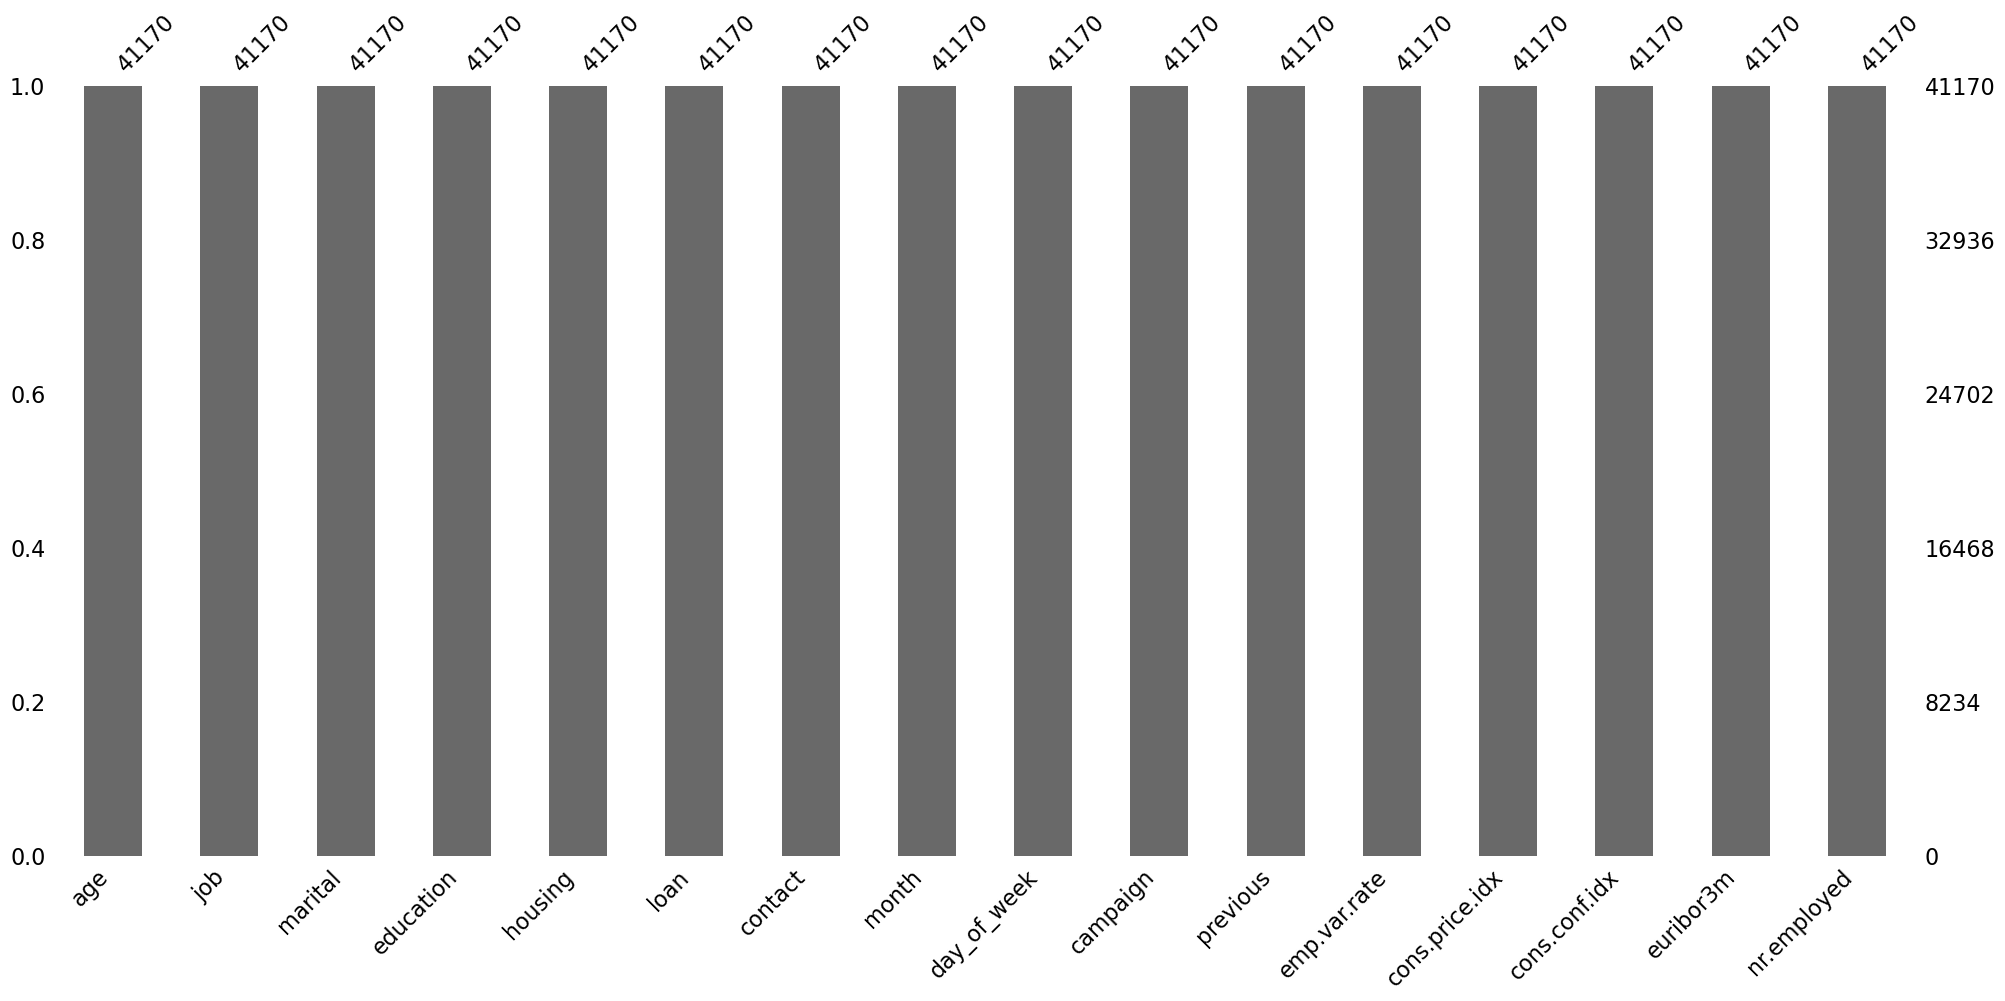

In [183]:
import missingno as msno

msno.bar(bank_df)

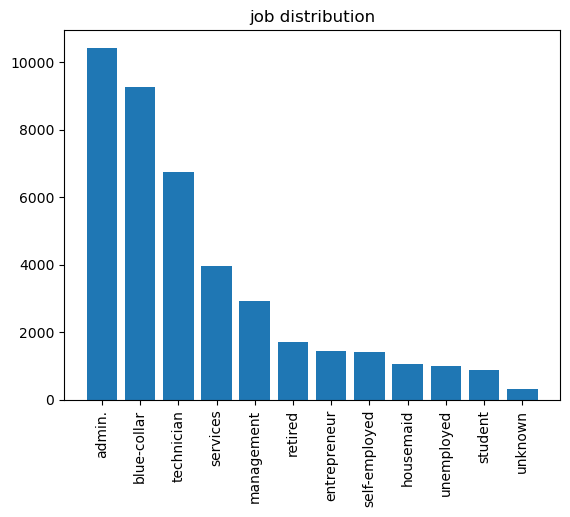

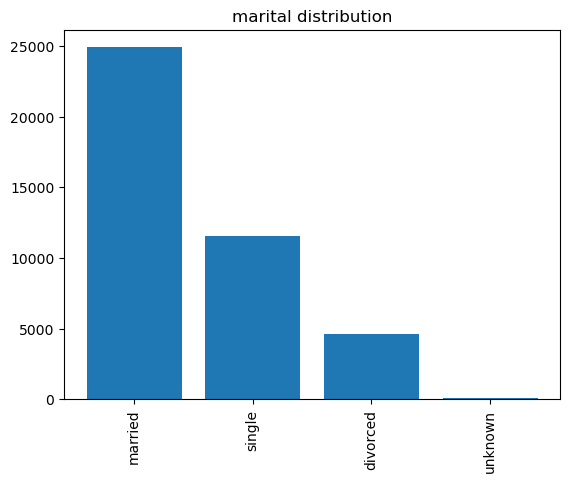

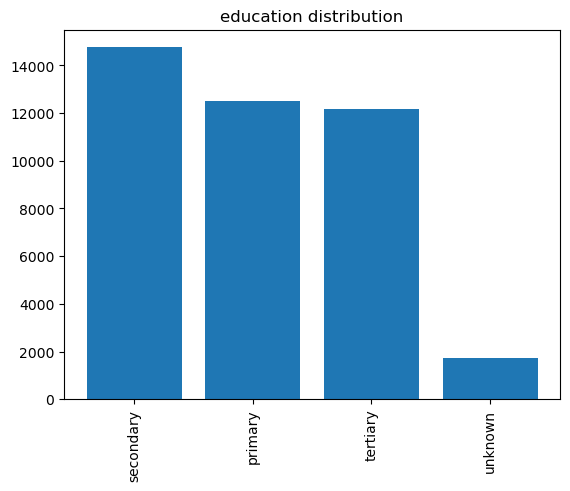

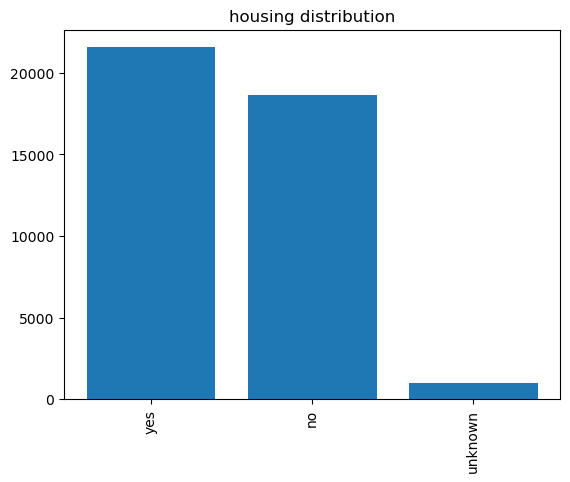

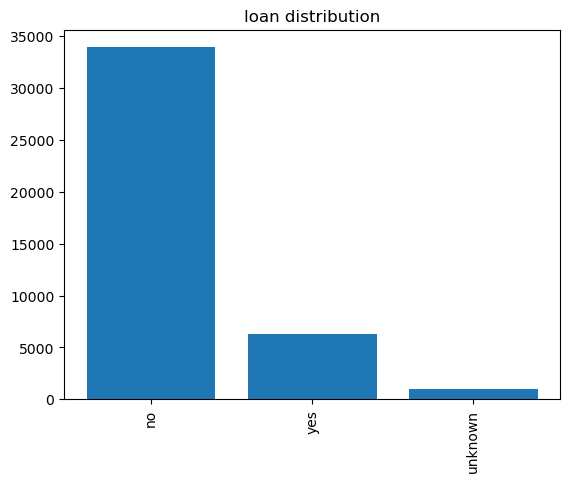

In [184]:
# plot class frequencies
# the categorical data contains values "unknown"
for column in bank_df.select_dtypes(include="object").columns:
    category_counts = bank_df[column].value_counts()
    labels = category_counts.index
    counts = category_counts.values
    plt.bar(labels, counts)
    plt.title(f'{column} distribution')
    plt.xticks(rotation=90, ha='center')
    plt.show()

Jak widać, będziemy tu mieli do czynienia z problemem klasyfikacji niezbalansowanej. Na szczęście funkcja kosztu w regresji logistycznej pozwala na dodanie **wag klas (class weights)**, aby przypisać większą wagę interesującej nas klasie pozytywnej. Scikit-learn dla wartości `class_weights="balanced"` obliczy wagi odwrotnie proporcjonalne do częstości danej klasy w zbiorze.

**Zadanie 9 (1.0 punkt)**

*Podział i preprocessing danych*

1. Dokonaj podziału zbioru na treningowy i testowy w proporcjach 75%-25%. Pamiętaj o użyciu podziału ze stratyfikacją (argument `stratify`), aby zachować proporcje klas. Ustaw `random_state=0`.
2. Stwórz `ColumnTransformer`, przetwarzający zmienne kategoryczne za pomocą `OneHotEncoder` (teraz już nie musimy robić `drop="first"`), a numeryczne za pomocą `StandardScaler`. Zaaplikuj go do odpowiednich kolumn.


In [185]:
from sklearn.model_selection import train_test_split
categorical_features = bank_df.select_dtypes(include="object").columns
numerical_features = bank_df.select_dtypes(exclude="object").columns

X_train, X_test, y_train, y_test = train_test_split(
    bank_df, y, test_size=0.25, random_state=0, stratify=y
)

In [186]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

scaler = StandardScaler()

categorical_pipeline = Pipeline([
    ("encoder", one_hot_encoder)
])

numerical_pipeline = Pipeline([
    ("scaler", scaler)
])

column_transformer = ColumnTransformer([
    ('categorical', categorical_pipeline, categorical_features),
    ('numerical', numerical_pipeline, numerical_features),
], verbose_feature_names_out=False)

# fit and transform
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

In [187]:
column_transformer

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['job', 'marital', 'education', 'housing', 'loan'], dtype='object')),
                                ('numerical',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['age', 'contact', 'month', 'day_of_week', 'campaign', 'previous',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed'],
      dtype='object'))],
                  verbose_feature_names_out=False)

### Metryki klasyfikacji binarnej

W klasyfikacji binarnej mamy tylko dwie klasy, z konwencji oznaczamy jedną klasę jako negatywną, a drugą - pozytywną. W naszym przypadku klasą negatywną będą osoby niezainteresowane lokatą - nie chcemy im pokazywać naszych reklam, bo to będzie raczej nieskuteczne, a reklama kosztuje. Naszym targetem będą osoby oznaczone klasą pozytywną.

Wytrenowaliśmy model, ale jak sprawdzić jakość jego działania? Metryki z regresji raczej za wiele nam nie pomogą. Potrzebujemy zdefiniować nowe.

#### Celność, dokładność (*Accuracy*)

Najprostszym sposobem oceny klasyfikacji jest sprawdzić, w ilu przypadkach się mylimy, a w ilu model odpowiada poprawnie. Ta metryka jest zwana ***accuracy***. Ma ona jednak zasadniczą wadę - kompletnie nie radzi sobie z klasami niezbalansowanymi.

Prosty przypadek - mamy zbiór danych, który pozwala na podstawie różnych parametrów medycznych wykryć rzadką chorobę, która zdarza się u 0.01% ludzi. Weźmy prosty klasyfikator, który zawsze zwraca klasę negatywną. Niby jest w oczywisty sposób kompletnie nieprzydatny, ale jednak dla losowej próbki ludzi dostanie ***celność*** równą 99.99%, bo, rzeczywiście, u większości tej choroby nie będzie.

Potrzebujemy bardziej skomplikowanej metryki, której nie da się tak łatwo oszukać.



#### Macierz pomyłek (*Confusion Matrix*)

Żeby zdefiniować taką metodę oceny klasyfikacji, musimy najpierw rozważyć jakie sytuacje mogą zdarzyć się przy klasyfikacji binarnej. Spójrzmy na tablicę poniżej:

<div>
<img src="confusion-matrix.png" width="500"/>
</div>

Występują tutaj przypadki:
* ***prawdziwie pozytywne*** (*true positive*) - model zwrócił klasę pozytywną (*positive*), i jest to prawda (*true*)
* ***prawdziwie negatwyne*** (*true negative*) - model zwrócił klasę negatywną (*negative*), i jest to prawda (*true*)
* ***fałszywie negatywne*** (*false negative*) - model zwrócił klasę negatywną (*negative*), ale nie jest to prawda (*false*)
* ***fałszywie pozytywne*** (*false positive*) - model zwrócił klasę pozytywną (*positive*), ale nie jest to prawda (*false*)

Mając powyższe punkty - możemy zdefiniować ***celność*** następująco:

$$
accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

czyli ilość przypadków, w których poprawnie zidentykowaliśmy klasę, podzieloną przez ilość wszystkich przypadków.



#### Precyzja (miara predykcyjna dodatnia) i czułość (*Precision & Recall*)

Jednak jak zauważyliśmy wcześniej, istnieją sytuacje, w których nie jest to właściwe podejście.

Zdecydowanie ciekawszą dla nas metryką może być stwierdzenie jaką część rekordów z klasą pozytywną model poprawnie rozpoznał. Pozwoli to nam powiedzieć, jak czuły jest nasz model na klasę pozytywną. Ta metryka nazywa się czułością (***recall***):

$$
recall = \frac{TP}{TP + FN}
$$

Jest o ilość przypadków, w których poprawnie rozpoznaliśmy klasę pozytywną, podzielona przez ilość wszystkich przypadków z klasą pozytywną.

Drugą korzystną dla nas metryką będzie stwierdzenie ile z osób, które zakwalifikowaliśmy do klasy pozytywne, rzeczywiście do niej należy. Pozwoli to oszacować, jak często mylimy się oznaczając rekord klasą pozytywną. Ta metryka nazywa się precyzją (***precision***):

$$
precision = \frac{TP}{TP + FP}
$$

Jest to ilość przypadków, w których poprawnie rozpoznaliśmy klasę pozytywną, podzielona przez ilość wszystkich przypadków, w których zwróciliśmy klasę pozytywną.

Ta metryka może być bardzo pomocna, na przykład, przy klasyfikacji spamu. Gorzej będzie, jeśli wrzucimy ważnego maila do spamu, niż przegapimy jakąś reklamę. Chcemy, aby jeśli coś zostało zaklasyfikowane jako spam, rzeczywiście nim było - chcemy jak najwyższą precyzję.


#### F1 score

Powyższe metryki mają wadę - pojedynczo można je łatwo oszukać:

* Czy chcemy idealną ***precyzję***? - wystarczy zawsze zwracać klasę negatywną (ważny mail nie trafi do spamu, jeśli żadnego z nich tam nie wrzucimy).
* Czy chcemy idealną ***czułość***? - zawsze zwracamy klasę pozytywną (na pewno nie pominiemy chorego pacjenta, jeśli każdemu powiemy, że jest chory).

Musimy stosować je w parze. Dla prostoty, często agregujemy je do jednej zagregowanej miary za pomocą średniej harmonicznej. W przypadku liczb z zakresu $[0, 1]$ (a z takimi mamy do czynienia), ona ma taką własność, że wartość wynikowa zawsze będzie bliższa mniejszej wartości. I im większa jest między nimi różnica, tym bardziej jest to widoczne. Przykładowo, dla pary $(100\%, 0\%)$ średnia harmoniczna wynosi $0\%$. Średnia harmoniczna z ***precyzji*** i ***czułości*** nazywana jest ***miarą F1*** (*F1 score*):

$$
F_1 = \frac{2 \cdot precision \cdot recall}{precision + recall}
$$

[Ten tutorial](https://mlu-explain.github.io/precision-recall/) ma świetne wizualizację, które w interaktywny sposób prezentują działanie powyższych metryk.

**Uwaga**:  indeks dolny w mierze $F_1$ oznacza, że mamy do czyninia z miarą, która daje taką samą wagę precyzji i czułości, ale w ogólnym przypadku jest to parametr, za pomocą którego możemy promować miarę, która ma dla nas większe znaczenie.

**Zadanie 10 (2.0 punkty)**

*Trening, tuning i analiza modeli*

1. Wytrenuj podstawowy model regresji logistycznej z użyciem `LogisticRegression`. Użyj wag klas (`class_weights="balanced"`). Przetestuj model, wypisując pecyzję, czułość oraz miarę F1 w procentach. **Uwaga:** Scikit-learn domyślnie stosuje tutaj regularyzację L2, więc przekaż `penalty="None"`.
2. Dokonaj tuningu modelu z regularyzacją L2 za pomocą `LogisticRegressionCV`:
    - sprawdź 100 wartości, wystarczy podać liczbę do `Cs`,
    - użyj 5-krotnej walidacji krzyżowej,
    - wybierz najlepszy model według metryki F1 (parametr `scoring`),
    - pamiętaj o `class_weights="balanced"` i `random_state=0`,
    - użyj `n_jobs=-1` dla przyspieszenia obliczeń (`-1` znaczy, że użyjemy wszystkich rdzeni do obliczeń),
    - przetestuj model, wypisując precyzję, czułość i miarę F1 w procentach.
    - **uwaga:** Scikit-learn stosuje tutaj konwencję, gdzie parametr `C` to odwrotność siły regularyzacji - im mniejszy, tym silniejsza regularyzacja.
3. Dokonaj analogicznego tuningu, ale dla regularyzacji L1. Użyj solwera SAGA. Przetestuj model, wypisując precyzję, czułość i miarę F1 w procentach.
4. Dokonaj analizy wytrenowanych modeli:
    - Oblicz miarę F1 na zbiorze treningowym modelu bez żadnej regularyzacji i porównaj go z wynikiem testowym; czy występuje tutaj overfitting?
    - Czy twoim zdaniem tworzenie modeli z regularyzacją ma sens w tym przypadku?

Napisz co, w twojej opinii, jest ważniejsze dla naszego problemu, ***precision*** czy ***recall***? Jak moglibyśmy, nie zmieniając modelu, zmienić ich stosunek?

In [188]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score

reg_logistic = LogisticRegression(class_weight="balanced", penalty=None)
reg_logistic.fit(X_test, y_test)

y_pred = reg_logistic.predict(X_test)

print("No regularization model") 
print(f"f1_score:        {100 * f1_score(y_pred, y_test):.2f}%")
print(f"precision_score: {100 * precision_score(y_pred, y_test):.2f}%")
print(f"recall_score:    {100 * recall_score(y_pred, y_test):.2f}%")

No regularization model
f1_score:        39.54%
precision_score: 66.35%
recall_score:    28.16%


In [189]:
from sklearn.linear_model import LogisticRegressionCV

reg_logisitic_cv = LogisticRegressionCV(Cs=100, cv=5, class_weight="balanced",
                                         random_state=0, n_jobs=-1, penalty="l2")

reg_logisitic_cv.fit(X_train, y_train)

y_pred = reg_logisitic_cv.predict(X_test)

print("L2 regularized model") 
print(f"f1_score:        {100 * f1_score(y_pred, y_test):.2f}%")
print(f"precision_score: {100 * precision_score(y_pred, y_test):.2f}%")
print(f"recall_score:    {100 * recall_score(y_pred, y_test):.2f}%")

L2 regularized model
f1_score:        37.83%
precision_score: 66.87%
recall_score:    26.38%


In [190]:
from sklearn.linear_model import LogisticRegressionCV

reg_logisitic_cv_l1 = LogisticRegressionCV(Cs=100, cv=5, penalty='l1', solver='saga',
 class_weight="balanced", random_state=0, n_jobs=-1)

reg_logisitic_cv_l1.fit(X_train, y_train)

y_pred = reg_logisitic_cv_l1.predict(X_test)

print("L1 regularized model") 
print(f"f1_score:        {100 * f1_score(y_pred, y_test):.2f}%")
print(f"precision_score: {100 * precision_score(y_pred, y_test):.2f}%")
print(f"recall_score:    {100 * recall_score(y_pred, y_test):.2f}%")

L1 regularized model
f1_score:        35.80%
precision_score: 69.89%
recall_score:    24.06%


In [191]:
y_pred = reg_logistic.predict(X_train)

print("No regularization - train data") 
print(f"f1_score:        {100 * f1_score(y_pred, y_train):.2f}%")
print(f"precision_score: {100 * precision_score(y_pred, y_train):.2f}%")
print(f"recall_score:    {100 * recall_score(y_pred, y_train):.2f}%")


y_pred = reg_logistic.predict(X_test)

print("\nNo regularization - test data") 
print(f"f1_score:        {100 * f1_score(y_pred, y_test):.2f}%")
print(f"precision_score: {100 * precision_score(y_pred, y_test):.2f}%")
print(f"recall_score:    {100 * recall_score(y_pred, y_test):.2f}%")

No regularization - train data
f1_score:        39.96%
precision_score: 66.52%
recall_score:    28.55%

No regularization - test data
f1_score:        39.54%
precision_score: 66.35%
recall_score:    28.16%


**Zadanie 11 (2.0 punkty)**

*Dodanie cech wielomianowych do regresji logistycznej*

1. Stwórz nowy pipeline do przetwarzania danych do regresji logistycznej, dodając `PolynomialFeatures` do zmiennych numerycznych przed standaryzacją. Wygeneruj cechy o stopniu 2, interakcje oraz potęgi, nie generuj interceptu.
2. Wytrenuj model regresji logistycznej bez regularyzacji na takim powiększonym zbiorze. Wypisz F1 treningowy oraz testowy w procentach.
3. Zdecyduj, czy jest sens tworzyć modele z regularyzacją. Jeżeli tak, to wytrenuj i dokonaj tuningu takich modeli. Jeżeli nie, to uzasadnij czemu.

In [192]:
pipeline = Pipeline([
    ('polynomial_features', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('classifier', LogisticRegression(class_weight="balanced", penalty=None))
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)


print(f"F1 for train data: {100 * f1_score(y_train, y_train_pred):.2f}%")
print(f"F1 for test data: {100 * f1_score(y_test, y_test_pred):.2f}%")

c:\Users\Nicolas\Documents\Semestr V\Podstawy Sztucznej Inteligencji\sztuczna-inteligencja\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1 for train data: 44.40%
F1 for test data: 42.89%


Wynik jest lepszy niż zwykłej regresji logistycznej, natomiast F1 zbioru treningowego i testowego jest ponownie bardzo do siebie zbliżone, nie mamy widocznego zjawiska overfittingu więc używanie regularyzacji nie przyniesie znaczących efektów

## Zadanie dodatkowe (3 punkty)

Z formalnego, statystycznego punktu widzenia regresja liniowa czyni szereg założeń ([Wikipedia](https://en.wikipedia.org/wiki/Linear_regression#Assumptions)):
1. Liniowość - relacja w danych może być reprezentowana jako `y=Xw`.
2. Normalność błędów - błędy (rezydua) mają rozkład normalny, wycentrowany na zerze.
3. Homoskedastyczność (stała wariancja) - wariancja błędu nie zależy od wartości docelowych `y`. Innymi słowy, nasz błąd będzie w przybliżeniu miał podobny "rozrzut" dla małych i dużych wartości `y`.
4. Niezależność błędów - błąd i `y` są niezależne (w sensie statystycznym). Innymi słowy, nie ma między nimi bezpośredniej relacji. Jeżeli nie pracujemy z szeregami czasowymi, to to założenie po prostu jest spełnione.
5. Brak współliniowości zmiennych - nie ma idealnej korelacji cech.

Testowanie tych własności nie zawsze jest oczywiste, a w szczególności Scikit-learn oferuje tutaj dość mało opcji, bo pochodzą one głównie z tradycyjnej statystyki.

1. Liniowość:
  - numerycznie: wysoki współczynnik dopasowania modelu $R^2$ na zbiorze treningowym, niski błąd (RMSE) na zbiorze treningowym oraz testowym
  - testem statystycznym: [Rainbow test](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.linear_rainbow.html) lub [Harvey Collier test](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.linear_harvey_collier.html)
  - graficznie: możliwe kiedy mamy 1/2 zmienne i da się narysować wykres zmiennej zależnej względem cech
2. Normalność błędów:
  - graficznie: robimy histogram rezyduów, powinien mieć kształt rozkładu normalnego i być wycentrowany na zerze
  - testem statystycznym: [Jarque-Bera test](https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test), [Omnibus normality test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html)
3. Homoskedastyczność:
  - graficznie: robimy scatter plot rezyduów dla wartości przewidywanych od najmniejszej do największej, nie powinno być na nim żadnych widocznych wzorców czy kształtów; [przykład 1](https://towardsdatascience.com/multivariant-linear-regression-e636a4f99b40), [przykład 2](https://www.vexpower.com/brief/homoskedasticity)
  - testem statystycznym: [Breusch–Pagan test](https://en.wikipedia.org/wiki/Breusch%E2%80%93Pagan_test) lub [Goldfeld-Quandt test](https://en.wikipedia.org/wiki/Goldfeld%E2%80%93Quandt_test)
4. Niezależność błędów - nie omawiam, bo dotyczy tylko szeregów czasowych.
5. Brak współliniowości zmiennych: numerycznie, sprawdzić korelacje zmiennych, lub współczynnik uwarunkowania macierzy `X`


W ramach zadania wytrenuj model regresji liniowej dla zbioru danych Ames Housing z użyciem biblioteki Statsmodels: [OLS docs](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html), [OLS](https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html), [Regression diagnostics](https://www.statsmodels.org/dev/examples/notebooks/generated/regression_diagnostics.html). Wytrenuj najpierw model bez regularyzacji, a następnie z regularyzacją L2 oraz L1. Nie przeprowadzaj tuningu, użyj tych wartości siły regularyzacji, które wyznaczyliśmy wcześniej.

Przetestuj założenia za pomocą testów statystycznych: Harvey Collier, Jarque-Bera, Breusch–Pagan. Współliniowość zmiennych zweryfikuj z użyciem współczynnika uwarunkowania. Zastosuj poziom istotności $\alpha=0.05$.

Czy założenia są spełnione w przypadku podstawowego modelu i/lub modeli z regularyzacją? Czy modele regularyzowane w lepszym stopniu spełniają założenia?